### 1. Problema 
Miegas vienas svarbiausių rodiklių, kurie nulemia žmogaus produktyvumą. Fizinis aktyvumas nemažai prisideda prie geros miego kokybės. Daugumoje literatūros šaltinių galima rasti, jog kiekvienas žmogus turi išsimiegoti bent 8 valandas per naktį, nueiti 1000 žingsniu bei užlipti bent 10 aukštų į viršų per dieną. Šie duomenys yra kaip standartas, kurio dažnai dauguma žmonių aklai laikosi, tačiau ar pasiekus šiuos tikslus, o gal net pralenkus galime pasiekti efektyviausią miego kokybę? Ar praėjusios dienos miego rodikliai įtakoja ateinančios dienos miego kokybę? Remiantis mano Garmin laikrodžio duomenimis surinktais nuo 2023-10-02 iki 2024-06-03 sukursiu modelį, kuris galėtų nustatyti kurie parametrai labiausiai įtakoja miego kokybę. 

In [1]:
import json
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
from scipy import stats

In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    RandomForestClassifier,
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    root_mean_squared_error,
)
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import xgboost.plotting as plotting

In [3]:
%load_ext jupyter_black
pd.set_option("display.max_columns", None)

### 2. Duomenų pasiruošimas

##### 2.1. Failų atidarymas ir užsikrovimas

Direktorija, kurioje yra patalpinti visi parsisiųti failai iš Garmin.

In [4]:
DIR = r"C:\Users\juuus\PycharmProjects\pythonProject\finito_garmin\Garmin"

Sukuriu funkciją, kuri peržiūri direktorijoje esančius duomenis ir grąžina informaciją kokie pavieniai failai ir kokie aplankalai yra saugomi direktorijoje. Ši funkcija padeda toliau procesuoti duomenų užsikrovimą.

In [5]:
def list_folders_and_files(directory: str) -> list:
    """
    Perziuri visa duotos direktorijos turini.
    :param directory: analizuojama direktorija
    :return: visus aplankalus ir failus esancius direktorijoje
    """
    if not os.path.exists(directory):
        raise FileNotFoundError(f"The directory '{directory}' does not exist.")

    folders = []
    files = []

    try:
        for entry in os.listdir(directory):
            path = os.path.join(directory, entry)
            if os.path.isdir(path):
                folders.append(entry)
            elif os.path.isfile(path):
                files.append(entry)
    except Exception as e:
        print(f"An error occurred: {e}")

    return folders, files

In [6]:
all_folders, garmin_files = list_folders_and_files(DIR)
print("Folders:", all_folders)
print("Files:", garmin_files)

Folders: ['.ipynb_checkpoints', 'DI-Connect-Metrics', 'DI-Connect-User', 'DI-Connect-Wellness']
Files: ['Activities.csv', 'consentHistory.json', 'customer.json', 'events.json']


Didžioji dalis duomenų yra pateikti json failais. Tolimesnė funkcija padeda nuskaityti json failus, kurie yra vieno lygio, juos normalizuoti bei paversti pandas formato lentelėmis. Funkcija yra naudojama pirmiausia nuskaityti failus, kurie direktorijoje yra pavieniai.

In [7]:
def read_json_file(file_location):
    with open(file_location) as f:
        return json.load(f)


def read_and_print_all_jsons(directory: str, file_list: list) -> dict:
    """
    Perziuri, perskaito ir pavercia df duotoje direktorijoje esancius visus json failus.
    :param directory: analizuojama direktorija
    :param file_list: analizuojamu json file sarasas
    :return: visu failu esanciu direktorijoje df, kurie yra zodyne
    """
    dataframes = {}
    for file in file_list:
        if file.endswith(".json"):
            print(file)
            data = read_json_file(directory + "\\" + file)
            df = pd.json_normalize(data, sep="_")
            display(df.head())
            key = os.path.splitext(file)[0]
            dataframes[key] = df

    return dataframes

In [8]:
dataframes = read_and_print_all_jsons(DIR, garmin_files)

consentHistory.json


,key,referenceId,referenceType,correlationId,consentTypeId,state,locale,source,version,createdDate,consentCreatedDate,actorId,metadata
0,8a7c1ec38afe47c8018b09dcd89b7a9c,758c983d-40d9-4a35-adb9-fa9e3f44d323,CUSTOMER,None,DI_CONNECT_INSIGHTS,GRANTED,en-LT,GCM-Android-4.71,31,2023-10-07T11:19:10.235Z,2023-10-07T11:19:10.235Z,None,None
1,8a7c59a78ae81c10018af16d31204355,758c983d-40d9-4a35-adb9-fa9e3f44d323,CUSTOMER,None,DI_CONNECT_STRAVA,GRANTED,en-LT,GCM-Android-4.71,48,2023-10-02T17:26:19.680Z,2023-10-02T17:26:19.680Z,None,None
2,8a7c89158ad14702018af16d87dc481a,758c983d-40d9-4a35-adb9-fa9e3f44d323,CUSTOMER,None,DI_CONNECT_STRAVA,GRANTED,en-LT,GCM-Android-4.71,48,2023-10-02T17:26:41.884Z,2023-10-02T17:26:19.680Z,None,None
3,8a7c92898b14e4fe018b17e12a616260,758c983d-40d9-4a35-adb9-fa9e3f44d323,CUSTOMER,None,DI_CONNECT_PRODUCT_IMPROVEMENT_DATA_USAGE,REVOKED,en-LT,GCM-Android-4.71,6,2023-10-10T04:38:34.337Z,2023-10-10T04:38:34.337Z,None,None
4,8a7cd1038adbdcd5018af167fa5c6b33,758c983d-40d9-4a35-adb9-fa9e3f44d323,CUSTOMER,None,DI_CONNECT_UPLOAD,GRANTED,en-LT,GCM-Android-4.71,59,2023-10-02T17:20:37.980Z,2023-10-02T17:20:37.978Z,None,None


customer.json


,id,firstName,middleName,lastName,fullName,namePrefix,nameSuffix,gender,displayName,username,primaryAddress,primaryPhoneNumber,locale,type,active,version,lastUpdateDateTime,createdDate,nextPurgeCheckDate,companyName,toBePurged,accountVerified,accountVerificationDate,legacyAccount,addresses,emailAddresses,phoneNumbers,foreignIdentifiers,loginInfo,primaryEmailAddress_emailAddress,primaryEmailAddress_type,primaryEmailAddress_primary,primaryEmailAddress_emailVerified,primaryEmailAddress_emailVerificationTimestamp,primaryEmailAddress_emailAddressId,customerLocation_countryCode,customerLocation_verified,customerLocation_verifiedTimestamp
0,None,Justina,None,None,Justina,None,None,None,None,JUUUSTE.G@GMAIL.COM,None,None,en_US,None,True,8,2024-05-30T18:26:16Z,2023-10-02T17:13:58Z,None,None,False,False,None,False,[],[],[],[],None,juuuste.g@gmail.com,None,True,False,None,None,LT,True,2023-10-02T17:13:59Z


events.json


,referenceId,referenceType,sourceSystem,sourceSystemVersion,platformId,actorId,userAgent,locale,locationCountry,eventDateTime,eventType,testMode,receivedDate,eventData_COMPLETION_STATUS,eventData_EVENT_ACTION,eventData_EVENT_SOURCE,eventData_X-actor,eventData_preferenceKey,eventData_preferenceValue,eventData_devicePk,eventData_request,eventData_profileVisibility
0,758c983d-40d9-4a35-adb9-fa9e3f44d323,CUSTOMER_GUID,ITW_CDS_SSO_WEB_PORTAL-ACCOUNT_MANAGEMENT_CENTER,None,ACCOUNT_MANAGEMENT_CENTER,None,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,en-US,LT,2024-05-30T18:26:17.237Z,IT_SSO_PORTAL_LOGIN,False,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,758c983d-40d9-4a35-adb9-fa9e3f44d323,CUSTOMER_GUID,Connect API Component,UNKNOWN,GARMIN_CONNECT,None,GC-API:pl-activityupload007,en-LT,LT,2024-05-20T13:36:56Z,CONNECT_HYDRATION,False,None,RECEIVED,UPDATED,PUT /usersummary-service/usersummary/hydration...,NaN,NaN,NaN,NaN,NaN,NaN
2,758c983d-40d9-4a35-adb9-fa9e3f44d323,CUSTOMER_GUID,Connect API Component,UNKNOWN,GARMIN_CONNECT,None,GC-API:pl-activityupload021,en-LT,LT,2024-04-20T06:51Z,CONNECT_HYDRATION,False,None,RECEIVED,UPDATED,PUT /usersummary-service/usersummary/hydration...,NaN,NaN,NaN,NaN,NaN,NaN
3,758c983d-40d9-4a35-adb9-fa9e3f44d323,CUSTOMER_GUID,Connect API Component,UNKNOWN,GARMIN_CONNECT,None,GC-API:pl-activityupload023,en-LT,LT,2024-04-17T19:39:01Z,CONNECT_HYDRATION,False,None,RECEIVED,UPDATED,PUT /usersummary-service/usersummary/hydration...,NaN,NaN,NaN,NaN,NaN,NaN
4,758c983d-40d9-4a35-adb9-fa9e3f44d323,CUSTOMER_GUID,Connect API Component,UNKNOWN,GARMIN_CONNECT,None,GC-API:pl-activityupload009,en-LT,LT,2024-04-09T04:44:20Z,CONNECT_HYDRATION,False,None,RECEIVED,UPDATED,PUT /usersummary-service/usersummary/hydration...,NaN,NaN,NaN,NaN,NaN,NaN


Iteruojama per direktorijoje esamus aplankalus ir failus juose. Naudojama ta pati aukščiau aprašyta funkcija, kuri leidžia nuskaityti ir transformuoti json failus.

In [9]:
# perziurima informacija aplankalu failuose
foldersdf = {}
for folder in all_folders[1:]:
    folder_location = os.path.join(DIR, folder)
    print(folder)
    print("")
    _, files = list_folders_and_files(folder_location)
    folder_dataframes = read_and_print_all_jsons(folder_location, files)
    foldersdf.update(folder_dataframes)

DI-Connect-Metrics

MetricsAcuteTrainingLoad_20231004_20240112_116735852.json


,userProfilePK,calendarDate,deviceId,timestamp,acwrStatus,acwrStatusFeedback,dailyTrainingLoadAcute,dailyTrainingLoadChronic,acwrPercent,dailyAcuteChronicWorkloadRatio
0,116735852,1696636800000,3392680107,1696671964000,NONE,NONE,5,13,NaN,NaN
1,116735852,1696723200000,3392680107,1696758364000,NONE,NONE,27,13,NaN,NaN
2,116735852,1696809600000,3392680107,1696844764000,NONE,NONE,24,13,NaN,NaN
3,116735852,1696896000000,3392680107,1696931164000,NONE,NONE,22,13,NaN,NaN
4,116735852,1696982400000,3392680107,1697017564000,NONE,NONE,19,13,NaN,NaN


MetricsAcuteTrainingLoad_20240112_20240421_116735852.json


,userProfilePK,calendarDate,deviceId,timestamp,acwrPercent,acwrStatus,acwrStatusFeedback,dailyTrainingLoadAcute,dailyTrainingLoadChronic,dailyAcuteChronicWorkloadRatio
0,116735852,1705017600000,3392680107,1705037719000,20,LOW,FEEDBACK_1,157,293,0.5
1,116735852,1705017600000,3392680107,1705081278000,20,LOW,FEEDBACK_1,177,297,0.5
2,116735852,1705104000000,3392680107,1705133509000,16,LOW,FEEDBACK_1,132,290,0.4
3,116735852,1705104000000,3392680107,1705162627000,52,OPTIMAL,FEEDBACK_2,444,347,1.2
4,116735852,1705104000000,3392680107,1705165069000,57,OPTIMAL,FEEDBACK_3,477,353,1.3


MetricsAcuteTrainingLoad_20240421_20240730_116735852.json


,userProfilePK,calendarDate,deviceId,timestamp,acwrPercent,acwrStatus,acwrStatusFeedback,dailyTrainingLoadAcute,dailyTrainingLoadChronic,dailyAcuteChronicWorkloadRatio
0,116735852,1713657600000,3392680107,1713674855000,47,OPTIMAL,FEEDBACK_2,250,219,1.1
1,116735852,1713744000000,3392680107,1713761556000,38,OPTIMAL,FEEDBACK_2,216,219,0.9
2,116735852,1713830400000,3392680107,1713848256000,33,OPTIMAL,FEEDBACK_2,183,219,0.8
3,116735852,1713830400000,3392680107,1713884556000,33,OPTIMAL,FEEDBACK_2,183,219,0.8
4,116735852,1713916800000,3392680107,1713932534000,25,LOW,FEEDBACK_1,150,219,0.6


MetricsHeatAltitudeAcclimation_20231004_20240112_116735852.json


,userProfilePK,deviceId,calendarDate,timestamp,altitudeAcclimationTimestamp,previousAltitudeAcclimationTimestamp,heatAcclimationTimestamp,previousHeatAcclimationTimestamp,altitudeAcclimation,previousAltitudeAcclimation,heatAcclimationPercentage,previousHeatAcclimationPercentage,altitudeTrend,currentAltitude,prevAltitude,acclimationPercentage,prevAcclimationPercentage,altitudeAcclimationLocalTimestamp
0,116735852,3392680107,2023-10-13,2023-10-12T22:01:04.0,2023-10-12T22:01:04.0,2023-10-12T22:01:04.0,2023-10-12T22:01:04.0,2023-10-12T22:01:04.0,850,0,0,0,ACCLIMATIZING,0,0,0,0,2023-10-13T00:01:04.0
1,116735852,3392680107,2023-10-14,2023-10-13T22:01:04.0,2023-10-13T22:01:04.0,2023-10-12T22:01:04.0,2023-10-13T22:01:04.0,2023-10-13T22:01:04.0,850,850,0,0,ACCLIMATIZED,60,0,0,0,2023-10-14T00:01:04.0
2,116735852,3392680107,2023-10-14,2023-10-14T07:50:11.0,2023-10-14T07:50:11.0,2023-10-12T22:01:04.0,2023-10-14T07:50:11.0,2023-10-14T07:50:11.0,850,850,0,0,ACCLIMATIZED,0,0,0,0,2023-10-14T09:50:11.0
3,116735852,3392680107,2023-10-15,2023-10-14T22:01:06.0,2023-10-14T22:01:06.0,2023-10-14T07:50:11.0,2023-10-14T22:01:06.0,2023-10-14T22:01:06.0,850,850,0,0,ACCLIMATIZED,0,0,0,0,2023-10-15T00:01:06.0
4,116735852,3392680107,2023-10-15,2023-10-15T07:41:55.0,2023-10-15T07:41:55.0,2023-10-15T07:41:55.0,2023-10-15T07:41:55.0,2023-10-15T07:41:55.0,0,0,0,0,NaN,0,0,0,0,2023-10-15T09:41:55.0


MetricsHeatAltitudeAcclimation_20240112_20240421_116735852.json


,userProfilePK,deviceId,calendarDate,timestamp,altitudeAcclimationTimestamp,previousAltitudeAcclimationTimestamp,heatAcclimationTimestamp,previousHeatAcclimationTimestamp,altitudeAcclimation,previousAltitudeAcclimation,heatAcclimationPercentage,previousHeatAcclimationPercentage,currentAltitude,prevAltitude,acclimationPercentage,prevAcclimationPercentage,altitudeAcclimationLocalTimestamp,altitudeTrend
0,116735852,3392680107,2024-01-12,2024-01-11T22:01:46.0,2024-01-11T22:01:46.0,2024-01-11T22:01:46.0,2024-01-11T22:01:46.0,2024-01-11T22:01:46.0,0,0,0,0,0,0,0,0,2024-01-12T00:01:46.0,NaN
1,116735852,3392680107,2024-01-12,2024-01-12T17:41:18.0,2024-01-12T17:41:18.0,2024-01-12T17:41:18.0,2024-01-12T17:41:18.0,2024-01-12T17:41:18.0,0,0,0,0,0,0,0,0,2024-01-12T19:41:18.0,NaN
2,116735852,3392680107,2024-01-13,2024-01-12T22:01:49.0,2024-01-12T22:01:49.0,2024-01-12T22:01:49.0,2024-01-12T22:01:49.0,2024-01-12T22:01:49.0,0,0,0,0,0,0,0,0,2024-01-13T00:01:49.0,NaN
3,116735852,3392680107,2024-01-13,2024-01-13T16:17:07.0,2024-01-13T16:17:07.0,2024-01-13T16:17:07.0,2024-01-13T16:17:07.0,2024-01-13T16:17:07.0,0,0,0,0,0,0,0,0,2024-01-13T18:17:07.0,NaN
4,116735852,3392680107,2024-01-13,2024-01-13T16:57:49.0,2024-01-13T16:57:49.0,2024-01-13T16:57:49.0,2024-01-13T16:57:49.0,2024-01-13T16:57:49.0,0,0,0,0,0,0,0,0,2024-01-13T18:57:49.0,NaN


MetricsHeatAltitudeAcclimation_20240421_20240730_116735852.json


,userProfilePK,deviceId,calendarDate,timestamp,altitudeAcclimationTimestamp,previousAltitudeAcclimationTimestamp,heatAcclimationTimestamp,previousHeatAcclimationTimestamp,altitudeAcclimation,previousAltitudeAcclimation,heatAcclimationPercentage,previousHeatAcclimationPercentage,currentAltitude,prevAltitude,acclimationPercentage,prevAcclimationPercentage,altitudeAcclimationLocalTimestamp,altitudeTrend
0,116735852,3392680107,2024-04-21,2024-04-21T21:02:35.0,2024-04-21T21:02:35.0,2024-04-21T21:02:35.0,2024-04-21T21:02:35.0,2024-04-21T21:02:35.0,0,0,0,0,0,0,0,0,2024-04-22T00:02:35.0,NaN
1,116735852,3392680107,2024-04-23,2024-04-22T21:02:36.0,2024-04-22T21:02:36.0,2024-04-22T21:02:36.0,2024-04-22T21:02:36.0,2024-04-22T21:02:36.0,0,0,0,0,0,0,0,0,2024-04-23T00:02:36.0,NaN
2,116735852,3392680107,2024-04-24,2024-04-23T21:02:36.0,2024-04-23T21:02:36.0,2024-04-23T21:02:36.0,2024-04-23T21:02:36.0,2024-04-23T21:02:36.0,0,0,0,0,0,0,0,0,2024-04-24T00:02:36.0,NaN
3,116735852,3392680107,2024-04-25,2024-04-24T21:02:36.0,2024-04-24T21:02:36.0,2024-04-24T21:02:36.0,2024-04-24T21:02:36.0,2024-04-24T21:02:36.0,0,0,0,0,0,0,0,0,2024-04-25T00:02:36.0,NaN
4,116735852,3392680107,2024-04-26,2024-04-25T22:02:36.0,2024-04-25T22:02:36.0,2024-04-25T22:02:36.0,2024-04-25T22:02:36.0,2024-04-25T22:02:36.0,0,0,0,0,0,0,0,0,2024-04-26T00:02:36.0,NaN


MetricsMaxMetData_20231004_20240112_116735852.json


,userProfilePK,calendarDate,deviceId,updateTimestamp,vo2MaxValue,fitnessAge,fitnessAgeDescription,analyzerMethod,maxMet,maxMetCategory,calibratedData,sport,subSport
0,116735852,2023-10-04,3392680107,2023-10-03T21:10:33.0,43.0,20,2,5.0,12.404343,GENERIC,0,NaN,NaN
1,116735852,2023-10-04,3392680107,2023-10-03T23:00:48.0,44.0,20,2,5.0,12.452789,GENERIC,0,NaN,NaN
2,116735852,2023-10-05,3392680107,2023-10-04T21:04:23.0,44.0,NaN,NaN,NaN,12.449341,GENERIC,0,NaN,NaN
3,116735852,2023-10-05,3392680107,2023-10-05T03:24:57.0,44.0,NaN,NaN,NaN,12.446533,GENERIC,0,NaN,NaN
4,116735852,2023-10-07,3392680107,2023-10-07T08:41:32.0,44.0,NaN,NaN,NaN,12.444199,GENERIC,0,NaN,NaN


MetricsMaxMetData_20240112_20240421_116735852.json


,userProfilePK,calendarDate,deviceId,updateTimestamp,sport,subSport,vo2MaxValue,maxMet,maxMetCategory,calibratedData
0,116735852,2024-01-12,3392680107,2024-01-12T17:41:18.0,WALKING,GENERIC,43.0,12.257874,GENERIC,1
1,116735852,2024-01-19,3392680107,2024-01-19T19:52:26.0,WALKING,GENERIC,43.0,12.257797,GENERIC,1
2,116735852,2024-01-27,3392680107,2024-01-27T12:41:18.0,WALKING,GENERIC,43.0,12.263214,GENERIC,1
3,116735852,2024-01-28,3392680107,2024-01-28T19:37:53.0,WALKING,GENERIC,43.0,12.353516,GENERIC,1
4,116735852,2024-02-02,3392680107,2024-02-03T03:10:18.0,WALKING,GENERIC,43.0,12.339111,GENERIC,1


MetricsMaxMetData_20240421_20240730_116735852.json


,userProfilePK,calendarDate,deviceId,updateTimestamp,vo2MaxValue,maxMet,maxMetCategory,calibratedData
0,116735852,2024-05-21,3392680107,2024-05-20T21:03:24.0,43.0,12.232819,GENERIC,0
1,116735852,2024-05-21,3392680107,2024-05-21T04:58:24.0,43.0,12.241516,GENERIC,0
2,116735852,2024-05-22,3392680107,2024-05-21T21:03:24.0,43.0,12.230606,GENERIC,0
3,116735852,2024-05-22,3392680107,2024-05-22T04:03:24.0,43.0,12.219955,GENERIC,0
4,116735852,2024-05-24,3392680107,2024-05-23T21:03:24.0,43.0,12.206223,GENERIC,0


RunRacePredictions_20231004_20240112_116735852.json


,userProfilePK,calendarDate,deviceId,timestamp,raceTime5K,raceTime10K,raceTimeHalf,raceTimeMarathon
0,116735852,2023-10-13,3392680107,2023-10-13T07:46:04.0,1514,3318,7786,18172
1,116735852,2023-10-13,3392680107,2023-10-12T22:01:04.0,1514,3318,7786,18172
2,116735852,2023-10-14,3392680107,2023-10-13T22:01:04.0,1514,3318,7786,18172
3,116735852,2023-10-14,3392680107,2023-10-14T06:57:57.0,1514,3318,7786,18172
4,116735852,2023-10-14,3392680107,2023-10-14T07:50:11.0,1896,3982,8951,19834


RunRacePredictions_20240112_20240421_116735852.json


,userProfilePK,calendarDate,deviceId,timestamp,raceTime5K,raceTime10K,raceTimeHalf,raceTimeMarathon
0,116735852,2024-01-12,3392680107,2024-01-12T05:35:19.0,1592,3422,7831,17684
1,116735852,2024-01-12,3392680107,2024-01-12T17:41:18.0,1595,3431,7856,17754
2,116735852,2024-01-12,3392680107,2024-01-11T22:01:46.0,1592,3422,7831,17684
3,116735852,2024-01-13,3392680107,2024-01-12T22:01:49.0,1595,3431,7856,17754
4,116735852,2024-01-13,3392680107,2024-01-13T08:11:49.0,1595,3431,7856,17754


RunRacePredictions_20240421_20240730_116735852.json


,userProfilePK,calendarDate,deviceId,timestamp,raceTime5K,raceTime10K,raceTimeHalf,raceTimeMarathon
0,116735852,2024-04-21,3392680107,2024-04-20T21:02:35.0,1702,3687,8474,19117
1,116735852,2024-04-21,3392680107,2024-04-21T04:47:35.0,1702,3687,8474,19117
2,116735852,2024-04-22,3392680107,2024-04-22T04:52:36.0,1702,3687,8474,19117
3,116735852,2024-04-22,3392680107,2024-04-21T21:02:35.0,1702,3687,8474,19117
4,116735852,2024-04-23,3392680107,2024-04-22T21:02:36.0,1786,3847,8809,19814


TrainingHistory_20231004_20240112_116735852.json


,userProfilePK,calendarDate,deviceId,timestamp,trainingStatus,trainingStatus2FeedbackPhrase,fitnessLevelTrend
0,116735852,2023-10-07,3392680107,2023-10-07T09:46:04.0,NO_STATUS,NO_STATUS_1,NaN
1,116735852,2023-10-08,3392680107,2023-10-08T09:46:04.0,NO_STATUS,NO_STATUS_1,NaN
2,116735852,2023-10-09,3392680107,2023-10-09T09:46:04.0,NO_STATUS,NO_STATUS_1,NaN
3,116735852,2023-10-10,3392680107,2023-10-10T09:46:04.0,NO_STATUS,NO_STATUS_1,NaN
4,116735852,2023-10-11,3392680107,2023-10-11T09:46:04.0,NO_STATUS,NO_STATUS_1,NaN


TrainingHistory_20240112_20240421_116735852.json


,userProfilePK,calendarDate,deviceId,timestamp,trainingStatus,fitnessLevelTrend,trainingStatus2FeedbackPhrase,sport,subSport
0,116735852,2024-01-12,3392680107,2024-01-12T05:35:19.0,RECOVERY,NO_RESULT,RECOVERY_1,NaN,NaN
1,116735852,2024-01-12,3392680107,2024-01-12T17:41:18.0,RECOVERY,NO_RESULT,RECOVERY_1,NaN,NaN
2,116735852,2024-01-13,3392680107,2024-01-13T08:11:49.0,RECOVERY,NO_RESULT,RECOVERY_1,NaN,NaN
3,116735852,2024-01-13,3392680107,2024-01-13T16:17:07.0,MAINTAINING,NO_RESULT,MAINTAINING_1,NaN,NaN
4,116735852,2024-01-13,3392680107,2024-01-13T16:57:49.0,PRODUCTIVE,NO_RESULT,PRODUCTIVE_1,NaN,NaN


TrainingHistory_20240421_20240730_116735852.json


,userProfilePK,calendarDate,deviceId,timestamp,sport,subSport,trainingStatus,fitnessLevelTrend,trainingStatus2FeedbackPhrase
0,116735852,2024-04-21,3392680107,2024-04-21T04:47:35.0,RUNNING,GENERIC,MAINTAINING,NO_CHANGE,MAINTAINING_2
1,116735852,2024-04-22,3392680107,2024-04-22T04:52:36.0,RUNNING,GENERIC,MAINTAINING,NO_CHANGE,MAINTAINING_2
2,116735852,2024-04-23,3392680107,2024-04-23T04:57:36.0,RUNNING,GENERIC,MAINTAINING,NO_CHANGE,MAINTAINING_2
3,116735852,2024-04-23,3392680107,2024-04-23T15:02:36.0,RUNNING,GENERIC,MAINTAINING,NO_CHANGE,MAINTAINING_2
4,116735852,2024-04-24,3392680107,2024-04-24T04:22:14.0,RUNNING,GENERIC,MAINTAINING,NO_CHANGE,MAINTAINING_2


DI-Connect-User

UserGoal_2023-06-25_2023-10-03.json


,userProfilePk,userGoalCategory,userGoalType,goalValue,startDate_date,updateDate_date,createDate_date
0,116735852,MANUAL,STEPS,10000.0,"Oct 2, 2023","Oct 2, 2023 5:46:32 PM","Oct 2, 2023 5:46:32 PM"


user_profile.json


,userName,firstName,emailAddress,gender,birthDate
0,juuuste.g@gmail.com,Justina,juuuste.g@gmail.com,FEMALE,1995-10-17


DI-Connect-Wellness

116735852_fitnessAgeData.json


,createTimestamp,asOfDateGmt,chronologicalAge,bmi,rhr,totalVigorousDays,totalVigorousIMs,numOfWeeksForIM,healthyBmi,healthyFat,vo2MaxForHealthyBmiFat,vo2MaxForHealthyActive,biometricVo2Max,currentBioAge,healthyAllBioAge,healthyBmiFatBioAge,healthyActiveBioAge,weightDataLastEntryDate,rhrLastEntryDate
0,2023-10-03T03:10:23.846,2023-10-02T00:00:00.0,27,24.913495,45,0,0,4,22.248201,22.075,40.735063,40.69922,39.978355,25.717552,23.390305,25.316441,25.33544,2023-10-02,2023-10-02
1,2023-10-03T03:10:25.33,2023-10-03T00:00:00.0,27,24.913495,46,0,0,4,22.248201,22.075,40.735063,40.69922,39.873270,25.773256,23.390305,25.316441,25.33544,2023-10-02,2023-10-03
2,2023-10-04T05:59:31.256,2023-10-04T00:00:00.0,27,24.913495,46,0,0,4,22.248201,22.075,40.735063,40.69922,39.873270,25.773256,23.390305,25.316441,25.33544,2023-10-02,2023-10-04
3,2023-10-05T11:27:21.144,2023-10-05T00:00:00.0,27,24.913495,47,0,0,4,22.248201,22.075,40.735063,40.69922,39.768185,25.828959,23.390305,25.316441,25.33544,2023-10-02,2023-10-05
4,2023-10-06T08:43:45.974,2023-10-06T00:00:00.0,27,24.913495,47,0,9,4,22.248201,22.075,40.735063,40.69922,39.768185,25.828959,23.390305,25.316441,25.33544,2023-10-02,2023-10-06


116735852_heartRateZones.json


,trainingMethod,zone1Floor,zone2Floor,zone3Floor,zone4Floor,zone5Floor,maxHeartRateUsed,restingHrAutoUpdateUsed,sport,changeState
0,HR_MAX,98,117,137,156,176,195,False,DEFAULT,UNCHANGED


116735852_MenstrualCycles.json


,userProfilePk,startDate,predictedPeriodLength,actualPeriodLength,predictedCycleLength,actualCycleLength,hormonalContraception,fertileWindowStart,fertileWindowLength,status,reportTimestamp,hasLoggedOvulationDay,createTimestamp,cycleType,applicableMenstrualCycleLength,applicablePeriodLength,initialPredictedPeriodLength,initialPredictedCycleLength
0,116735852,2023-09-16,5,5.0,28,28.0,NONE,11,7,PAST,2023-10-13T19:39:18.537,False,2023-10-02T20:23:32.983,IRREGULAR,28,5,NaN,NaN
1,116735852,2023-10-14,5,5.0,29,30.0,NONE,13,7,PAST,2023-11-11T12:12:40.492,False,2023-10-14T08:58:28.241,IRREGULAR,30,5,5.0,28.0
2,116735852,2023-11-13,5,5.0,29,28.0,NONE,11,7,PAST,2023-11-13T20:48:11.223,False,2023-11-13T20:48:11.223,IRREGULAR,28,5,5.0,29.0
3,116735852,2023-12-11,5,5.0,34,31.0,NONE,14,7,PAST,2024-01-09T15:58:23.361,False,2023-12-11T22:23:15.742,IRREGULAR,31,5,NaN,NaN
4,116735852,2024-01-11,5,5.0,29,26.0,NONE,9,7,PAST,2024-01-11T05:20:55.667,False,2024-01-11T05:20:55.667,IRREGULAR,26,5,NaN,NaN


2023-08-09_2023-11-17_116735852_sleepData.json


,sleepStartTimestampGMT,sleepEndTimestampGMT,calendarDate,sleepWindowConfirmationType,deepSleepSeconds,lightSleepSeconds,remSleepSeconds,awakeSleepSeconds,unmeasurableSeconds,averageRespiration,lowestRespiration,highestRespiration,retro,awakeCount,avgSleepStress,restlessMomentCount,sleepScores_overallScore,sleepScores_qualityScore,sleepScores_durationScore,sleepScores_recoveryScore,sleepScores_deepScore,sleepScores_remScore,sleepScores_lightScore,sleepScores_awakeningsCountScore,sleepScores_awakeTimeScore,sleepScores_combinedAwakeScore,sleepScores_restfulnessScore,sleepScores_interruptionsScore,sleepScores_feedback,sleepScores_insight,spo2SleepSummary_userProfilePk,spo2SleepSummary_deviceId,spo2SleepSummary_sleepMeasurementStartGMT,spo2SleepSummary_sleepMeasurementEndGMT,spo2SleepSummary_averageSPO2,spo2SleepSummary_averageHR,spo2SleepSummary_lowestSPO2
0,2023-10-02T20:48:00.0,2023-10-03T02:47:00.0,2023-10-03,ENHANCED_CONFIRMED_FINAL,4920,10560,2400.0,360,3300,12.0,9.0,15.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-10-03T23:23:00.0,2023-10-04T03:00:00.0,2023-10-04,ENHANCED_CONFIRMED_FINAL,1560,6120,5340.0,0,0,13.0,9.0,15.0,False,0.0,16.50,14.0,47.0,81.0,27.0,77.0,72.0,60.0,100.0,100.0,100.0,100.0,99.0,100.0,POSITIVE_SHORT_BUT_CONTINUOUS,NONE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-10-04T21:33:00.0,2023-10-05T03:20:00.0,2023-10-05,ENHANCED_CONFIRMED_FINAL,2640,11760,5280.0,1140,0,11.0,8.0,15.0,False,2.0,17.68,13.0,68.0,81.0,58.0,75.0,75.0,100.0,88.0,74.0,81.0,77.0,100.0,81.0,POSITIVE_SHORT_BUT_REFRESHING,NONE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-10-06T02:56:00.0,2023-10-06T08:28:30.0,2023-10-06,ENHANCED_CONFIRMED_FINAL,4380,14700,NaN,840,0,15.0,11.0,24.0,False,1.0,51.75,34.0,38.0,45.0,56.0,0.0,100.0,0.0,64.0,87.0,88.0,87.0,73.0,84.0,NEGATIVE_SHORT_AND_POOR_QUALITY,NONE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-10-06T22:51:00.0,2023-10-07T06:01:00.0,2023-10-07,ENHANCED_CONFIRMED_FINAL,3660,19440,2700.0,0,0,14.0,11.0,17.0,False,0.0,13.75,23.0,79.0,84.0,80.0,85.0,76.0,57.0,66.0,100.0,100.0,100.0,100.0,100.0,NEGATIVE_LONG_BUT_NOT_ENOUGH_REM,NONE,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2023-11-17_2024-02-25_116735852_sleepData.json


,sleepStartTimestampGMT,sleepEndTimestampGMT,calendarDate,sleepWindowConfirmationType,deepSleepSeconds,lightSleepSeconds,remSleepSeconds,awakeSleepSeconds,unmeasurableSeconds,averageRespiration,lowestRespiration,highestRespiration,retro,awakeCount,avgSleepStress,restlessMomentCount,spo2SleepSummary_userProfilePk,spo2SleepSummary_deviceId,spo2SleepSummary_sleepMeasurementStartGMT,spo2SleepSummary_sleepMeasurementEndGMT,spo2SleepSummary_averageSPO2,spo2SleepSummary_averageHR,spo2SleepSummary_lowestSPO2,sleepScores_overallScore,sleepScores_qualityScore,sleepScores_durationScore,sleepScores_recoveryScore,sleepScores_deepScore,sleepScores_remScore,sleepScores_lightScore,sleepScores_awakeningsCountScore,sleepScores_awakeTimeScore,sleepScores_combinedAwakeScore,sleepScores_restfulnessScore,sleepScores_interruptionsScore,sleepScores_feedback,sleepScores_insight
0,2023-11-16T21:48:00.0,2023-11-17T04:05:00.0,2023-11-17,ENHANCED_CONFIRMED_FINAL,4560,12480,4680.0,900,0,12.0,8.0,15.0,False,1,7.740000,24,116735852.0,3.392680e+09,2023-11-16T21:50:00.0,2023-11-17T03:59:00.0,90.0,50.0,77.0,78.0,94.0,66.0,100.0,100.0,84.0,92.0,87.0,87.0,87.0,95.0,89.0,POSITIVE_RECOVERING,POSITIVE_RESTFUL_DAY
1,2023-11-18T01:20:00.0,2023-11-18T05:38:00.0,2023-11-18,ENHANCED_CONFIRMED_FINAL,3780,11400,NaN,300,0,15.0,12.0,18.0,False,0,49.669998,10,116735852.0,3.392680e+09,2023-11-18T01:21:00.0,2023-11-18T03:54:00.0,92.0,72.0,84.0,33.0,50.0,37.0,0.0,100.0,0.0,66.0,100.0,100.0,100.0,100.0,100.0,NEGATIVE_SHORT_AND_POOR_QUALITY,NONE
2,2023-11-19T03:45:00.0,2023-11-19T08:27:00.0,2023-11-19,ENHANCED_CONFIRMED_FINAL,3840,12900,NaN,180,0,15.0,12.0,18.0,False,0,35.080002,10,116735852.0,3.392680e+09,2023-11-19T03:46:00.0,2023-11-19T03:59:00.0,92.0,72.0,91.0,35.0,50.0,45.0,0.0,100.0,0.0,64.0,100.0,100.0,100.0,100.0,100.0,NEGATIVE_SHORT_AND_POOR_QUALITY,NONE
3,2023-11-19T23:39:00.0,2023-11-20T04:31:00.0,2023-11-20,ENHANCED_CONFIRMED_FINAL,1680,12060,3660.0,120,0,12.0,9.0,14.0,False,0,12.180000,21,116735852.0,3.392680e+09,2023-11-19T23:40:00.0,2023-11-20T03:59:00.0,91.0,54.0,77.0,63.0,88.0,48.0,91.0,67.0,80.0,73.0,100.0,100.0,100.0,94.0,99.0,POSITIVE_SHORT_BUT_CONTINUOUS,POSITIVE_LATE_BED_TIME
4,2023-11-20T20:02:00.0,2023-11-21T04:13:00.0,2023-11-21,ENHANCED_CONFIRMED_FINAL,3180,20400,2880.0,3000,0,12.0,9.0,17.0,False,4,14.060000,41,116735852.0,3.392680e+09,2023-11-20T20:10:00.0,2023-11-21T03:58:00.0,90.0,56.0,80.0,67.0,66.0,85.0,84.0,72.0,59.0,64.0,32.0,50.0,41.0,81.0,47.0,NEGATIVE_LONG_BUT_DISCONTINUOUS,NEGATIVE_LATE_STRENUOUS_EXERCISE


2024-02-25_2024-06-04_116735852_sleepData.json


,sleepStartTimestampGMT,sleepEndTimestampGMT,calendarDate,sleepWindowConfirmationType,deepSleepSeconds,lightSleepSeconds,remSleepSeconds,awakeSleepSeconds,unmeasurableSeconds,averageRespiration,lowestRespiration,highestRespiration,retro,awakeCount,avgSleepStress,restlessMomentCount,spo2SleepSummary_userProfilePk,spo2SleepSummary_deviceId,spo2SleepSummary_sleepMeasurementStartGMT,spo2SleepSummary_sleepMeasurementEndGMT,spo2SleepSummary_averageSPO2,spo2SleepSummary_averageHR,spo2SleepSummary_lowestSPO2,sleepScores_overallScore,sleepScores_qualityScore,sleepScores_durationScore,sleepScores_recoveryScore,sleepScores_deepScore,sleepScores_remScore,sleepScores_lightScore,sleepScores_awakeningsCountScore,sleepScores_awakeTimeScore,sleepScores_combinedAwakeScore,sleepScores_restfulnessScore,sleepScores_interruptionsScore,sleepScores_feedback,sleepScores_insight
0,2024-02-25T03:22:00.0,2024-02-25T08:58:00.0,2024-02-25,ENHANCED_CONFIRMED_FINAL,1500,16320,1200.0,1140,0,13.0,10.0,16.0,False,1,44.799999,12,116735852.0,3.392680e+09,2024-02-25T03:23:00.0,2024-02-25T03:56:00.0,93.0,58.0,92.0,41.0,45.0,55.0,0.0,64.0,34.0,25.0,87.0,81.0,84.0,100.0,87.0,NEGATIVE_SHORT_AND_POOR_QUALITY,NEGATIVE_STRESSFUL_DAY
1,2024-02-26T01:50:00.0,2024-02-26T03:46:00.0,2024-02-26,ENHANCED_CONFIRMED_FINAL,2100,4740,NaN,120,0,16.0,13.0,18.0,False,0,45.779999,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,50.0,0.0,0.0,NaN,NaN,NaN,100.0,100.0,100.0,93.0,99.0,NEGATIVE_SHORT_AND_POOR_QUALITY,NONE
2,2024-02-26T22:14:00.0,2024-02-27T05:30:00.0,2024-02-27,ENHANCED_CONFIRMED_FINAL,4860,19080,2160.0,60,0,14.0,11.0,24.0,False,0,15.740000,28,116735852.0,3.392680e+09,2024-02-26T22:15:00.0,2024-02-27T03:59:00.0,91.0,58.0,80.0,76.0,82.0,82.0,79.0,93.0,45.0,69.0,100.0,100.0,100.0,96.0,99.0,NEGATIVE_LONG_BUT_NOT_ENOUGH_REM,NONE
3,2024-02-27T22:08:00.0,2024-02-28T03:46:00.0,2024-02-28,ENHANCED_CONFIRMED_FINAL,2580,14760,2940.0,0,0,12.0,9.0,15.0,False,0,12.560000,19,116735852.0,3.392680e+09,2024-02-27T22:09:00.0,2024-02-28T03:46:00.0,91.0,55.0,82.0,71.0,87.0,61.0,90.0,73.0,67.0,69.0,100.0,100.0,100.0,100.0,100.0,POSITIVE_CONTINUOUS,POSITIVE_RESTFUL_DAY
4,2024-02-28T23:32:00.0,2024-02-29T04:31:00.0,2024-02-29,ENHANCED_CONFIRMED_FINAL,5400,10800,1680.0,60,0,13.0,9.0,16.0,False,0,24.370001,15,116735852.0,3.392680e+09,2024-02-28T23:33:00.0,2024-02-29T04:00:00.0,91.0,61.0,80.0,59.0,79.0,50.0,61.0,100.0,51.0,87.0,100.0,100.0,100.0,100.0,100.0,NEGATIVE_SHORT_AND_NONRECOVERING,NONE


HydrationLogFile_2023-07-24_2023-11-01.json


,userProfilePK,calendarDate,persistedTimestampGMT,timestampLocal,hydrationSource,valueInML,activityId,capped,estimatedSweatLossInML,duration,uuid_uuid
0,116735852,2023-10-07,2023-10-07T14:55:11.256,2023-10-07T11:41:33.0,GARMIN_ACTIVITY,0.0,12214076689,False,2371.0,22259.095703,4f4988ff-7294-4e3d-9e3a-4e728af871ec
1,116735852,2023-10-08,2023-10-08T11:49:48.253,2023-10-08T13:55:33.0,GARMIN_ACTIVITY,0.0,12226510857,False,388.0,3234.679932,07ed4783-3ae0-42c3-a5c5-664821c02edd
2,116735852,2023-10-14,2023-10-14T07:59:54.473,2023-10-14T09:22:07.0,GARMIN_ACTIVITY,0.0,12308058059,False,335.0,1326.224976,15c35316-16a3-4f0d-ba96-d03ad329db04
3,116735852,2023-10-15,2023-10-15T08:11:23.533,2023-10-15T09:11:54.0,GARMIN_ACTIVITY,0.0,12322004801,False,370.0,1436.265015,6bcd2e5c-6c43-41ef-8443-6f3c034949fe
4,116735852,2023-10-15,2023-10-15T14:25:49.276,2023-10-15T15:54:59.0,GARMIN_ACTIVITY,0.0,12328222931,False,139.0,1045.751953,60035539-7d81-4493-a442-3b7ff9b55087


HydrationLogFile_2023-11-01_2024-02-09.json


,userProfilePK,calendarDate,persistedTimestampGMT,timestampLocal,hydrationSource,valueInML,activityId,capped,estimatedSweatLossInML,duration,uuid_uuid
0,116735852,2023-11-01,2023-11-01T11:27:36.833,2023-11-01T13:05:46.0,GARMIN_ACTIVITY,0.0,12554840121,False,296.0,1202.349976,6e2fa8d2-efbb-472a-8e70-2723a61f432e
1,116735852,2023-11-05,2023-11-05T17:59:20.190,2023-11-05T19:27:57.0,GARMIN_ACTIVITY,0.0,12612634830,False,414.0,1621.031006,c8657e3f-2cc5-40e9-bb2c-db9c19e41965
2,116735852,2023-11-08,2023-11-08T17:19:35.0,2023-11-08T19:01:08.0,GARMIN_ACTIVITY,0.0,12652308457,False,300.0,1087.433960,2412e87e-eddc-4b98-b62f-bdb1634fa821
3,116735852,2023-11-20,2023-11-20T17:00:52.770,2023-11-20T18:22:45.0,GARMIN_ACTIVITY,0.0,12807372065,False,347.0,2016.207031,7d3b5063-c532-48d1-8ec9-1316e0b7c19c
4,116735852,2023-11-20,2023-11-20T17:34:29.973,2023-11-20T19:02:03.0,GARMIN_ACTIVITY,0.0,12807820030,False,455.0,1920.770020,61741f8b-4bec-4d3f-b063-73719c147ca9


HydrationLogFile_2024-02-09_2024-05-19.json


,userProfilePK,calendarDate,persistedTimestampGMT,timestampLocal,hydrationSource,valueInML,activityId,capped,estimatedSweatLossInML,duration,uuid_uuid
0,116735852,2024-02-13,2024-02-13T19:31:34.122,2024-02-13T20:54:54.0,GARMIN_ACTIVITY,0.0,13949080288,False,583.0,2100.827881,0cd28914-5d9f-42c2-bef4-ee7fd91ccd08
1,116735852,2024-02-14,2024-02-14T15:55:38.184,2024-02-14T17:43:13.0,GARMIN_ACTIVITY,0.0,13960857258,False,137.0,720.437012,21479434-04ba-4afb-8f9e-a703c1ac40cd
2,116735852,2024-02-14,2024-02-14T16:58:24.842,2024-02-14T18:03:35.0,GARMIN_ACTIVITY,0.0,13961809031,False,493.0,3018.843994,306eeafd-141a-4b0b-9abf-82f85784dbfb
3,116735852,2024-02-16,2024-02-16T07:27:40.455,2024-02-16T08:56:29.0,GARMIN_ACTIVITY,0.0,13984383228,False,187.0,1524.614014,3ae7bd56-b375-4a66-aa60-7a3366edc652
4,116735852,2024-02-16,2024-02-16T19:17:30.474,2024-02-16T15:35:56.0,GARMIN_ACTIVITY,0.0,13993212822,False,1862.0,12014.121094,ebadc9d7-2f70-4cf4-ba40-c3baa783ab6b


UDSFile_2023-08-09_2023-11-17.json


,userProfilePK,calendarDate,uuid,durationInMilliseconds,totalKilocalories,activeKilocalories,bmrKilocalories,wellnessKilocalories,remainingKilocalories,wellnessTotalKilocalories,wellnessActiveKilocalories,totalSteps,dailyStepGoal,totalDistanceMeters,wellnessDistanceMeters,wellnessStartTimeGmt,wellnessEndTimeGmt,wellnessStartTimeLocal,wellnessEndTimeLocal,highlyActiveSeconds,activeSeconds,moderateIntensityMinutes,vigorousIntensityMinutes,floorsAscendedInMeters,floorsDescendedInMeters,userIntensityMinutesGoal,userFloorsAscendedGoal,minHeartRate,maxHeartRate,restingHeartRate,currentDayRestingHeartRate,restingHeartRateTimestamp,includesWellnessData,includesActivityData,includesCalorieConsumedData,includesSingleMeasurement,includesContinuousMeasurement,includesAllDayPulseOx,includesSleepPulseOx,source,minAvgHeartRate,maxAvgHeartRate,version,averageMonitoringEnvironmentAltitude,allDayStress_userProfilePK,allDayStress_calendarDate,allDayStress_aggregatorList,bodyBattery_userProfilePK,bodyBattery_calendarDate,bodyBattery_chargedValue,bodyBattery_drainedValue,bodyBattery_bodyBatteryVersion,bodyBattery_bodyBatteryStatList,respiration_userProfilePK,respiration_calendarDate,respiration_avgWakingRespirationValue,respiration_highestRespirationValue,respiration_lowestRespirationValue,respiration_latestRespirationValue,respiration_latestRespirationTimeGMT,restingCaloriesFromActivity,hydration_userProfilePK,hydration_calendarDate,hydration_valueInML,hydration_activityIntakeInML,hydration_goalInML,hydration_capped,hydration_sweatLossInML,hydration_adjustedGoalInML,hydration_lastEntryTimestampLocal,averageSpo2Value,lowestSpo2Value,latestSpo2Value,latestSpo2ValueReadingTimeGmt,latestSpo2ValueReadingTimeLocal
0,116735852,2023-10-02,05fd683ff6824a4c9f2555724cbb1c2b,86400000,1806.0,0.0,1806.0,1806.0,1806.0,1806.0,0.0,60,10000,45,45,2023-10-01T21:00:00.0,2023-10-02T21:00:00.0,2023-10-02T00:00:00.0,2023-10-03T00:00:00.0,0,257,0,0,0.000,0.000,150,10,43,70,45,45,1696280400000,True,False,False,False,False,False,False,0,44,65,85080002,48.0,116735852,2023-10-02,"[{'type': 'TOTAL', 'averageStressLevel': 3, 'a...",116735852,2023-10-02,22,0,1.0,"[{'bodyBatteryStatType': 'HIGHEST', 'statsValu...",116735852,2023-10-02,13.0,15.0,11.0,13.0,2023-10-02T21:00:00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,116735852,2023-10-03,2d4c6e791a2d43f3bf7fdad5c8d3a2ca,86400000,2075.0,269.0,1806.0,2075.0,2075.0,2075.0,269.0,10068,10000,7667,7667,2023-10-02T21:00:00.0,2023-10-03T21:00:00.0,2023-10-03T00:00:00.0,2023-10-04T00:00:00.0,3130,5813,0,0,71.489,38.761,150,10,45,101,47,48,1696366800000,True,False,False,False,False,False,False,0,45,99,77580002,68.0,116735852,2023-10-03,"[{'type': 'TOTAL', 'averageStressLevel': 23, '...",116735852,2023-10-03,63,69,1.0,"[{'bodyBatteryStatType': 'HIGHEST', 'statsValu...",116735852,2023-10-03,13.0,19.0,9.0,14.0,2023-10-03T20:55:00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,116735852,2023-10-04,040b6e52522d4b1da441f0fe7686e2e6,86400000,2160.0,354.0,1806.0,2160.0,2160.0,2160.0,354.0,12533,10000,9546,9546,2023-10-03T21:00:00.0,2023-10-04T21:00:00.0,2023-10-04T00:00:00.0,2023-10-05T00:00:00.0,4094,7622,0,0,48.768,50.662,150,10,48,113,48,50,1696453200000,True,False,False,False,False,False,False,0,49,113,81840002,79.0,116735852,2023-10-04,"[{'type': 'TOTAL', 'averageStressLevel': 29, '...",116735852,2023-10-04,30,59,2.0,"[{'bodyBatteryStatType': 'HIGHEST', 'statsValu...",116735852,2023-10-04,13.0,18.0,9.0,13.0,2023-10-04T20:55:00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,116735852,2023-10-05,42afce7e45ca4ff7a84446e7661687f8,86400000,2015.0,209.0,1806.0,2015.0,2015.0,2015.0,209.0,8663,10000,6554,6554,2023-10-04T21:00:00.0,2023-10-05T21:00:00.0,2023-10-05T00:00:00.0,2023-10-06T00:00:00.0,3841,4456,0,0,30.480,42.536,150,10,34,101,48,49,1696539600000,True,False,False,False,False,False,False,0,34,101,80640002,73.0,116735852,2023-10-05,"[{'type': 'TOTAL', 'averageStressLevel': 25, '...",1167

UDSFile_2023-11-17_2024-02-25.json


,userProfilePK,calendarDate,uuid,durationInMilliseconds,totalKilocalories,activeKilocalories,bmrKilocalories,wellnessKilocalories,remainingKilocalories,wellnessTotalKilocalories,wellnessActiveKilocalories,totalSteps,dailyStepGoal,totalDistanceMeters,wellnessDistanceMeters,wellnessStartTimeGmt,wellnessEndTimeGmt,wellnessStartTimeLocal,wellnessEndTimeLocal,highlyActiveSeconds,activeSeconds,moderateIntensityMinutes,vigorousIntensityMinutes,floorsAscendedInMeters,floorsDescendedInMeters,userIntensityMinutesGoal,userFloorsAscendedGoal,minHeartRate,maxHeartRate,restingHeartRate,currentDayRestingHeartRate,restingHeartRateTimestamp,includesWellnessData,includesActivityData,includesCalorieConsumedData,includesSingleMeasurement,includesContinuousMeasurement,includesAllDayPulseOx,includesSleepPulseOx,source,minAvgHeartRate,maxAvgHeartRate,version,averageSpo2Value,lowestSpo2Value,latestSpo2Value,latestSpo2ValueReadingTimeGmt,latestSpo2ValueReadingTimeLocal,averageMonitoringEnvironmentAltitude,allDayStress_userProfilePK,allDayStress_calendarDate,allDayStress_aggregatorList,bodyBattery_userProfilePK,bodyBattery_calendarDate,bodyBattery_chargedValue,bodyBattery_drainedValue,bodyBattery_bodyBatteryVersion,bodyBattery_bodyBatteryStatList,respiration_userProfilePK,respiration_calendarDate,respiration_avgWakingRespirationValue,respiration_highestRespirationValue,respiration_lowestRespirationValue,respiration_latestRespirationValue,respiration_latestRespirationTimeGMT,restingCaloriesFromActivity,hydration_userProfilePK,hydration_calendarDate,hydration_valueInML,hydration_activityIntakeInML,hydration_goalInML,hydration_capped,hydration_sweatLossInML,hydration_adjustedGoalInML,hydration_lastEntryTimestampLocal,isVigorousDay
0,116735852,2023-11-17,88fc5e2e5b2f48b7b8492b660ab1f0fc,86400000,2153.0,347.0,1806.0,2153.0,2153.0,2153.0,347.0,11746,10000,8900,8900,2023-11-16T22:00:00.0,2023-11-17T22:00:00.0,2023-11-17T00:00:00.0,2023-11-18T00:00:00.0,3799,5442,0,0,37.244,52.500,150,10,46,116,48,48,1700258400000,True,False,False,False,False,True,True,0,46,114,54780002,92.0,77,93,2023-11-17T22:00:00.0,2023-11-18T00:00:00.0,147.0,116735852,2023-11-17,"[{'type': 'TOTAL', 'averageStressLevel': 31, '...",116735852,2023-11-17,55,86,2.0,"[{'bodyBatteryStatType': 'HIGHEST', 'statsValu...",116735852,2023-11-17,13.0,21.0,8.0,11.0,2023-11-17T22:00:00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,116735852,2023-11-18,3952473d1afa4acc86cf70db2ecc038a,86400000,2366.0,560.0,1806.0,2366.0,2366.0,2366.0,560.0,18985,10000,14376,14376,2023-11-17T22:00:00.0,2023-11-18T22:00:00.0,2023-11-18T00:00:00.0,2023-11-19T00:00:00.0,2775,9818,0,0,19.089,30.192,150,10,45,118,47,47,1700344800000,True,False,False,False,False,True,True,0,46,116,2,91.0,84,94,2023-11-18T21:10:00.0,2023-11-18T23:10:00.0,83.0,116735852,2023-11-18,"[{'type': 'TOTAL', 'averageStressLevel': 39, '...",116735852,2023-11-18,34,35,2.0,"[{'bodyBatteryStatType': 'HIGHEST', 'statsValu...",116735852,2023-11-18,13.0,19.0,9.0,10.0,2023-11-18T22:00:00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,116735852,2023-11-19,0a19c8b7811c41dc8d80db6e0bde0e02,86400000,2221.0,415.0,1806.0,2221.0,2221.0,2221.0,415.0,9622,10000,7294,7294,2023-11-18T22:00:00.0,2023-11-19T22:00:00.0,2023-11-19T00:00:00.0,2023-11-20T00:00:00.0,2011,6438,13,5,10.318,6.939,150,10,53,139,48,57,1700431200000,True,False,False,False,False,True,True,0,53,139,2,93.0,84,96,2023-11-19T21:43:00.0,2023-11-19T23:43:00.0,128.0,116735852,2023-11-19,"[{'type': 'TOTAL', 'averageStressLevel': 33, '...",116735852,2023-11-19,49,29,2.0,"[{'bodyBatteryStatType': 'HIGHEST', 'statsValu...",116735852,2023-11-19,14.0,22.0,11.0,15.0,2023-11-19T21:44:00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,116735852,2023-11-20,6f12fb4f346a40189d1b095736692a31,86400000,2631.0,825.0,1806.0,2631.0,2631.0,2631.0,825.0,15541,10000,13513,13513,2023-11-19T22:00:00.0,2023-11-20T22:00:00.0,2023-11-20T00:00:00.0,2023-11-21T00:00:00.0,6748,7240,15,45,30.480,36.039,150,10,44,184,48,48,1700517600000,T

UDSFile_2024-02-25_2024-06-04.json


,userProfilePK,calendarDate,uuid,durationInMilliseconds,totalKilocalories,activeKilocalories,bmrKilocalories,wellnessKilocalories,remainingKilocalories,wellnessTotalKilocalories,wellnessActiveKilocalories,totalSteps,dailyStepGoal,totalDistanceMeters,wellnessDistanceMeters,wellnessStartTimeGmt,wellnessEndTimeGmt,wellnessStartTimeLocal,wellnessEndTimeLocal,highlyActiveSeconds,activeSeconds,moderateIntensityMinutes,vigorousIntensityMinutes,isVigorousDay,floorsAscendedInMeters,floorsDescendedInMeters,userIntensityMinutesGoal,userFloorsAscendedGoal,minHeartRate,maxHeartRate,restingHeartRate,currentDayRestingHeartRate,restingHeartRateTimestamp,includesWellnessData,includesActivityData,includesCalorieConsumedData,includesSingleMeasurement,includesContinuousMeasurement,includesAllDayPulseOx,includesSleepPulseOx,source,minAvgHeartRate,maxAvgHeartRate,version,averageSpo2Value,lowestSpo2Value,latestSpo2Value,latestSpo2ValueReadingTimeGmt,latestSpo2ValueReadingTimeLocal,averageMonitoringEnvironmentAltitude,allDayStress_userProfilePK,allDayStress_calendarDate,allDayStress_aggregatorList,bodyBattery_userProfilePK,bodyBattery_calendarDate,bodyBattery_chargedValue,bodyBattery_drainedValue,bodyBattery_bodyBatteryVersion,bodyBattery_bodyBatteryStatList,respiration_userProfilePK,respiration_calendarDate,respiration_avgWakingRespirationValue,respiration_highestRespirationValue,respiration_lowestRespirationValue,respiration_latestRespirationValue,respiration_latestRespirationTimeGMT,restingCaloriesFromActivity,hydration_userProfilePK,hydration_calendarDate,hydration_valueInML,hydration_activityIntakeInML,hydration_goalInML,hydration_capped,hydration_sweatLossInML,hydration_adjustedGoalInML,hydration_lastEntryTimestampLocal
0,116735852,2024-02-25,86bd41b0e85c4c4999ba1b730783a51b,86400000,2067.0,256.0,1811.0,2067.0,2067.0,2067.0,256.0,5963,10000,4567,4567,2024-02-24T22:00:00.0,2024-02-25T22:00:00.0,2024-02-25T00:00:00.0,2024-02-26T00:00:00.0,1936,4570,0,0,False,11.201,15.821,150,10,51,122,49.0,54.0,1.708898e+12,True,False,False,False,False,True,True,0,52,122,77520002,91.0,78.0,91.0,2024-02-25T22:00:00.0,2024-02-26T00:00:00.0,121.0,116735852,2024-02-25,"[{'type': 'TOTAL', 'averageStressLevel': 38, '...",116735852,2024-02-25,33,38,2.0,"[{'bodyBatteryStatType': 'HIGHEST', 'statsValu...",116735852,2024-02-25,13.0,20.0,10.0,11.0,2024-02-25T22:00:00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,116735852,2024-02-26,267f653a4b55422eabdc460078496035,86400000,1993.0,182.0,1811.0,1993.0,1993.0,1993.0,182.0,6140,10000,4660,4660,2024-02-25T22:00:00.0,2024-02-26T22:00:00.0,2024-02-26T00:00:00.0,2024-02-27T00:00:00.0,3223,3522,5,0,False,38.681,13.479,150,10,54,119,49.0,53.0,1.708985e+12,True,False,False,False,False,True,False,0,55,116,2,90.0,82.0,96.0,2024-02-26T21:52:00.0,2024-02-26T23:52:00.0,127.0,116735852,2024-02-26,"[{'type': 'TOTAL', 'averageStressLevel': 39, '...",116735852,2024-02-26,2,1,2.0,"[{'bodyBatteryStatType': 'HIGHEST', 'statsValu...",116735852,2024-02-26,13.0,18.0,10.0,14.0,2024-02-26T22:00:00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,116735852,2024-02-27,d88f9678a7764dff90dd841cf3dd3597,86400000,1933.0,122.0,1811.0,1933.0,1933.0,1933.0,122.0,4570,10000,3457,3457,2024-02-26T22:00:00.0,2024-02-27T22:00:00.0,2024-02-27T00:00:00.0,2024-02-28T00:00:00.0,2097,2927,0,0,False,23.773,19.036,150,10,46,109,50.0,52.0,1.709071e+12,True,False,False,False,False,True,True,0,48,109,52980002,92.0,80.0,90.0,2024-02-27T21:58:00.0,2024-02-27T23:58:00.0,132.0,116735852,2024-02-27,"[{'type': 'TOTAL', 'averageStressLevel': 23, '...",116735852,2024-02-27,67,42,2.0,"[{'bodyBatteryStatType': 'HIGHEST', 'statsValu...",116735852,2024-02-27,13.0,24.0,9.0,11.0,2024-02-27T22:00:00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,116735852,2024-02-28,617dd5aebc7f40d0814fc39a582cc17e,86400000,1945.0,134.0,1811.0,1945.0,1945.0,1945.0,134.0,5168,10000,3910,3910,2024-02-27T22:00:00.0,2024-02-28T22:00:00.0,2024-02-28T00:00:00.0,2024-02-29T00:00:00.0,3097,4351,0,0,False,9.950,9.055,150,1

Peržiūrėjus aukščiau sugeneruotų json failų lentelių pirmas eilutes buvo nustatyta, jog specifinis USD failas, kuris talpina nemažai reikalingos informacijos yra kelių lygių json failas, kuris pilnai nebuvo išskleistas naudojantis pirmąją formule.

##### 2.2 USD failų užsikrovimas
Toliau yra pateikiama informacija bei funkcijos, kurių pagalba šis specifinis failas buvo paverstas į pandas formato lentelę.

In [10]:
def flatten_dict(d, parent_key="", sep="."):
    """
    Specialus sakoto json failo eiluciu tiesinimas, pirmasis tiesinimas.
    Parameters:
    :param d: (dict) Json formato failas.
    :param parent_key: (str): pirminis raktas (default '').
    :param sep: (str) skiriamasis zenklas, kuris yra naudojamas tarp sujungtu eiluciu(default '.').
    :return: dict: istiesinta zodyna.
    """
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [11]:
def sanitize_one_row_df(df, col_name, name):
    """
    Iteruoja per duota df, ismeta specifinius stulpelius, o likusius pervadina
    Parameters:
    :param df: paduodamas dataframe
    :param col_name: (str): stulpelio pavadinimas dataframe
    :param name: najas stulpelio vardas
    :return: dict: nauja dataframe
    """
    df = df.drop(columns=col_name)
    df.columns = [name + col for col in df.columns]
    return df.reset_index(drop=True)


def flatten_listed_dicts(list_dicts, col_name, col_values):
    """
    Funkcija islygina df esancius zodynus iteruodamas per kiekviena stulpeli naudodamas sanitize_one_row_df funkcija.
    Parameters:
    :param list_dicts: zodynai esantys df
    :param col_name: (str): stulpelio pavadinimas dataframe
    :param col_values: (str) stulpelio reiksmes dataframe
    :return: sujungta dataframe.
    """
    output = []
    flat_df = pd.json_normalize(list_dicts)
    for value in col_values:
        output.append(
            sanitize_one_row_df(flat_df[flat_df[col_name] == value], col_name, value)
        )

    return pd.concat(output, axis=1)

In [12]:
def nested_record_to_pd(record):
    """
    Funkcija istiesina specifinius laukus, naudodamas flatten_listed_dicts funkcija, kurie pradiniame json faile yra keliu lygiu
    Parameters:
    :param record: json failas istiesintas pirminiame tiesinime
    :return: sujungta dataframe su sutvarkytais specifiniais laukais
    """
    normalized_record = pd.json_normalize(flatten_dict(record))
    allDayStress_data = flatten_listed_dicts(
        normalized_record["allDayStress.aggregatorList"].iloc[0],
        "type",
        ["TOTAL", "AWAKE", "ASLEEP"],
    )
    bodyBattery_data = flatten_listed_dicts(
        normalized_record["bodyBattery.bodyBatteryStatList"].iloc[0],
        "bodyBatteryStatType",
        ["HIGHEST", "LOWEST"],
    )
    normalized_record = normalized_record.drop(
        columns=["allDayStress.aggregatorList", "bodyBattery.bodyBatteryStatList"]
    )
    return pd.concat(
        [normalized_record.reset_index(drop=True), allDayStress_data, bodyBattery_data],
        axis=1,
    )

In [13]:
def create_usd_file_to_pd(nested_json_list):
    """
    Funkcija uzsikrauna pirmini df ir iteruoja per kiekviena eilute pritaikydamas nested_record_to_pd funkcija
    Parameters:
    :param nested_json_list: pirminis uzsikrautas json df
    :return: atsidarytu failu sujungta dataframe galutini
    """
    output = []
    for n_json in nested_json_list:
        output.append(nested_record_to_pd(n_json))
    return pd.concat(output, axis=0).reset_index(drop=True)

In [14]:
USD_files_list = files[9:]


def usdfil_to_pd_full(files_list):
    """
    Funkcija atsidaro specifinius json failus pateiktus sarase, pirminis atsidarymas
    Parameters:
    :param files_list: json failu sarasa
    :return: atsidarytu failu sujungta dataframe galutini
    """
    usdfilesdf = []
    for file_name in files_list:
        nested_json = read_json_file(DIR + "\\DI-Connect-Wellness\\" + file_name)
        df = create_usd_file_to_pd(nested_json)
        usdfilesdf.append(df)
    return pd.concat(usdfilesdf, axis=0).reset_index(drop=True)


usdfile = usdfil_to_pd_full(USD_files_list)

Peržiūrėjus visus užkrautus failus buvo identifikuoti saugantys aktualiausią informaciją, kuri toliau padės duomenų analizėje, bei modelio kurime:
 - Hydration failai
 - Maxmetdata failai
 - Training hist failai
 - Sleep data failai
 - Activities failai
 - USD failai
   
##### 2.3 Atrinktų aktualių failų pasivertimas pilnomis lentelėmis.

Visi json failai buvo saugomi tam tikrais periodais, dėl šios priežasties kiekvienos rūšies failus reikėjo sujungti tarpusavyje. 
Activities failas yra specifinis ir yra kito formato, nei visi pagrindiniai failai. Activities failas yra CSV formato ir jo užsikrovimas yra pateiktas apačioje. Tolimesnis darbas bus vykdomas su šiame žingsnyje užsikrautais failais. 

In [15]:
# Hydration failai
hydration1 = foldersdf["HydrationLogFile_2023-07-24_2023-11-01"]
hydration2 = foldersdf["HydrationLogFile_2023-11-01_2024-02-09"]
hydration3 = foldersdf["HydrationLogFile_2024-02-09_2024-05-19"]
hydration = pd.concat([hydration1, hydration2, hydration3], ignore_index=True)

In [16]:
# MaxmetData failai
maxmetdata1 = foldersdf["MetricsMaxMetData_20231004_20240112_116735852"]
maxmetdata2 = foldersdf["MetricsMaxMetData_20240112_20240421_116735852"]
maxmetdata3 = foldersdf["MetricsMaxMetData_20240421_20240730_116735852"]
maxmetdata = pd.concat([maxmetdata1, maxmetdata2, maxmetdata3], ignore_index=True)

In [17]:
# Training history failai
training_hist1 = foldersdf["TrainingHistory_20231004_20240112_116735852"]
training_hist2 = foldersdf["TrainingHistory_20240112_20240421_116735852"]
training_hist3 = foldersdf["TrainingHistory_20240421_20240730_116735852"]
training_hist = pd.concat(
    [training_hist1, training_hist2, training_hist3], ignore_index=True
)

In [18]:
# Sleep Data failai
sleepdata1 = foldersdf["2023-08-09_2023-11-17_116735852_sleepData"]
sleepdata2 = foldersdf["2023-11-17_2024-02-25_116735852_sleepData"]
sleepdata3 = foldersdf["2024-02-25_2024-06-04_116735852_sleepData"]
sleep = pd.concat([sleepdata1, sleepdata2, sleepdata3], ignore_index=True)

In [19]:
activities = pd.read_csv("Garmin/Activities.csv")

### 3. Duomenų tvarkymas
Sukuriamos dvi funkcijos skirtos pirminiam duomenų išvalymui iš visų lentelių. Kadangi visi json failai buvo kurti tokiu pačiu principu visiems jiems galima pritaikyti pirminį duomenų išvalymą. Šiame žingsnyje pašalinami stulpeliai, kuriuose yra tik po vieną reikšmę per visą stulpelio ilgį, duplikatai, datos stulpelis paverčiamas datos tipu, panaikinami stulpeliai su neaktulia informacija
Duplikatų patikrinimas kiekvienai lentelei buvo vykdomas atskirai, patikrinus ir nustačius, jog reikšmingų duplikatų nėra ir pritaikyta duplikatų pašalinimo formulė.

#### 3.1 Duomenų tvarkymo formulės

In [20]:
activities = activities.rename(columns={"Date": "calendarDate"})

In [21]:
def drop_columns_same_one_value(df):
    """
    funkcija panaikinti stulpelius, kuriose yra tik viena reiksme
    :pram df: Dataframe, kuriame bus tikrinami stulpeliai
    :return: sutvarkyta df be stulpeliu, kuriuose yra tik viena reiksme
    """
    for column in df.columns:
        try:
            if df[column].nunique() == 1:
                df = df.drop(columns=[column])
        except KeyError:
            print(f"Column '{column}' not found in DataFrame.")

    return df


def clean_df(df):
    """
    Isvalo df nuo nereikalingu duomenu
    :param df: perduodamas tvarkyti df
    :return: sutvarkytas df
    """
    df["calendarDate"] = pd.to_datetime(df["calendarDate"])
    columns_to_drop = ["uuid_uuid", "uuid", "userProfilePK", "deviceId"]
    df = df.drop(columns=columns_to_drop, errors="ignore")
    df = df.dropna(axis=1, how="all")
    df = df.drop_duplicates(keep="first")
    df = drop_columns_same_one_value(df)
    return df

In [22]:
# isvalymo funkcijos pritaikymas visiems failams
hydration = clean_df(hydration)
usdfile = clean_df(usdfile)
maxmetdata = clean_df(maxmetdata)
training_hist = clean_df(training_hist)
sleep = clean_df(sleep)
activities = clean_df(activities)

#### 3.2 VO2 Maxmetdata ir Hydration failai

Maxmetdata failuose yra pasiliekama informacija apie VO2 rezultatą, kuris kinta atitinkamai pagal datą. Papildomo duomenų tvarkymo šiai lentelei neprireikė, jokių nežinomų reikšmių nėra. 


VO2 maksimumas – tai skaičius, kuris apibūdina jūsų širdies ir kvėpavimo sistemos pajėgumą. Juo stebimas maksimalus deguonies kiekis, kurį jūsų kūnas gali sunaudoti per vieną intensyvios mankštos minutę. Ši informacija yra būtina, norint suprasti jūsų gebėjimą sutelkti jėgas fizinei veiklai per aerobinės energijos kelius. Kitaip tariant, kuo aukštesnis jūsų VO2 maksimumas, tuo daugiau deguonies galite importuoti, transportuoti ir panaudoti, aerobiniu būdu transformuodami maistinių medžiagų suteikiamą energiją į fizinę veiklą.

https://www.garmin.com/lt-LT/garmin-technology/health-science/fitness-tracking/

In [23]:
maxmetdata = maxmetdata[["calendarDate", "vo2MaxValue"]]

In [140]:
maxmetdata.head()

,calendarDate,vo2MaxValue
0,2023-10-04,43.0
1,2023-10-04,44.0
2,2023-10-05,44.0
3,2023-10-05,44.0
4,2023-10-07,44.0


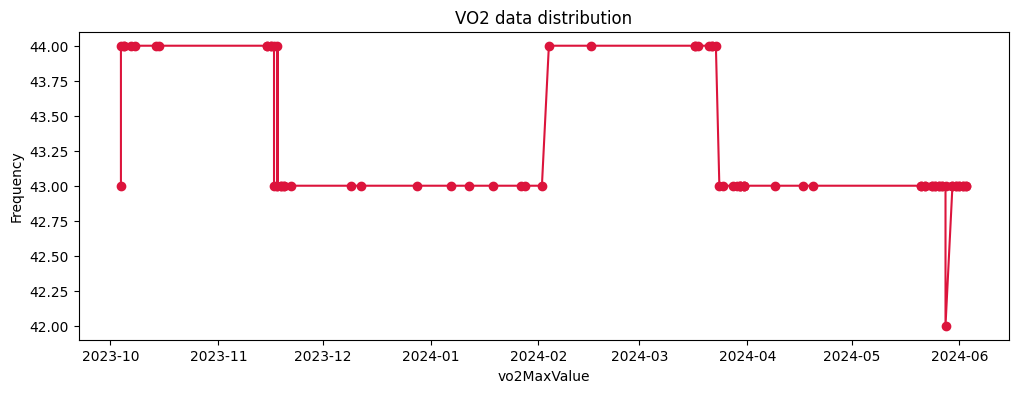

In [24]:
plt.figure(figsize=(12, 4))
plt.plot(
    maxmetdata["calendarDate"], maxmetdata["vo2MaxValue"], marker="o", color="crimson"
)
plt.xlabel("vo2MaxValue")
plt.ylabel("Frequency")
plt.title("VO2 data distribution")
plt.show()

Iš pateikto **grafiko** matyti galima identifikuoti, jog per visą duomenų imties laikotarpį buvo du periodai kada fizinė forma pagal VO2 maksimumo reikšmę buvo geriausia: 2023-10 - 2023-12 ir 2024-02 - 2024-04. Paskutinio mėnesio duomenys rodo prasčiausią VO2 maksimumo lygį.


#### 3.3 Hydration data failai
Šiame faile yra pateikiamas preliminarus skysčių netekimas per nurodytą laikotarpį užfiksuotas per sporto veiklas. Failo imtis nėra didelė ir duomenų kiekis priklauso nuo to, kiek buvo užfiksuotų sporto veiklų. Jokių nežinomų duomenų nėra, skysčių netekimas per laikotarpį pateikiamas ml. 

In [25]:
hydration = hydration[["calendarDate", "estimatedSweatLossInML"]]

In [141]:
hydration.head()

,calendarDate,estimatedSweatLossInML
0,2023-10-07,2371.0
1,2023-10-08,388.0
2,2023-10-14,335.0
3,2023-10-15,370.0
4,2023-10-15,139.0


#### 3.4 Hydration failo ir VO2 failo sujungimas
Šis pirminis duomenų sujungimas parodys kaip kito VO2 lygis sporto užsiėmimų metu. 

In [26]:
all_hydr_act = pd.merge(hydration, maxmetdata, on="calendarDate", how="outer")

In [27]:
# issimetam dublikatus, o nan reiksmes pasikeiciam 0
all_hydr_act = all_hydr_act.drop_duplicates().fillna(0)

In [28]:
# susigrupuojam duomenis pagal data, sweat reiksmes sudedam, VO2 paliekam tik paskutine reiksme, nes ji svarbiausia dienos pabaigoje
agg_funcs = {"estimatedSweatLossInML": "sum", "vo2MaxValue": "last"}
all_hydr_act = all_hydr_act.groupby("calendarDate").agg(agg_funcs).reset_index()

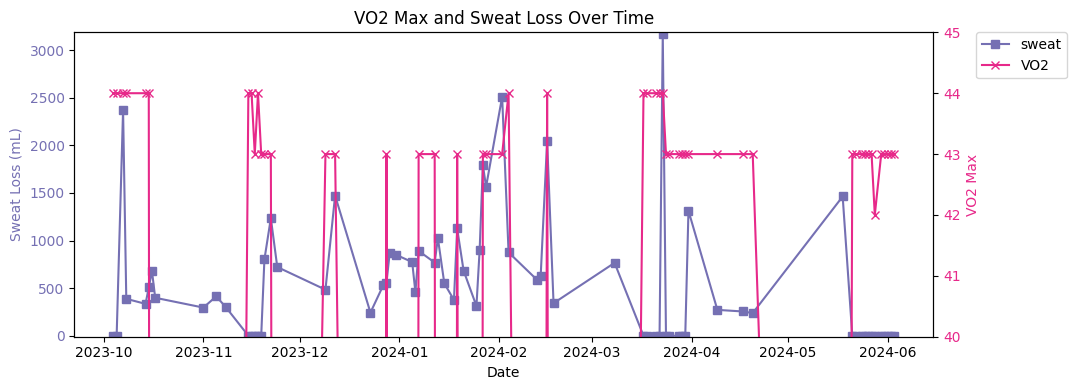

In [29]:
colormap = cm.Dark2.colors
fig, ax1 = plt.subplots(figsize=(10, 4))

ax1.plot(
    all_hydr_act["calendarDate"],
    all_hydr_act["estimatedSweatLossInML"],
    marker="s",
    color=colormap[2],
    label="sweat",
)
ax1.set_xlabel("Date")
ax1.set_ylabel("Sweat Loss (mL)", color=colormap[2])
ax1.tick_params(axis="y", labelcolor=colormap[2])

ax1.set_ylim(
    [
        all_hydr_act["estimatedSweatLossInML"].min() - 10,
        all_hydr_act["estimatedSweatLossInML"].max() + 20,
    ]
)

ax2 = ax1.twinx()
ax2.plot(
    all_hydr_act["calendarDate"],
    all_hydr_act["vo2MaxValue"],
    marker="x",
    color=colormap[3],
    label="VO2",
)
ax2.set_ylabel("VO2 Max", color=colormap[3])
ax2.tick_params(axis="y", labelcolor=colormap[3])

ax2.set_ylim([40, 45])

plt.title("VO2 Max and Sweat Loss Over Time")
fig.tight_layout()

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines_1 + lines_2,
    labels_1 + labels_2,
    loc="upper left",
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0.0,
)

plt.show()

Iš pateikto **grafiko** galima identifikuoti, jog sportinių veiklų metu kuomet yra netenkama daugiau skysčių VO2 maksimumo reikšmė taip pat yra didžiausia.

#### 3.5 Training history failas
Training history failas fiksuoja treniravimosi būklę kiekvieną dieną. Statuso žinutė gali būti:

- NO_STATUS (Būklės nėra) - Per mažai duomenų, negalima nustatyti statuso;
- RECOVERY (Jėgų atgavimas) - Lengva veikla, nei įprastai, o fizinio pasirengimo lygis išlieka pastovus arba šiek tiek mažėja.
- DETRAINING (Sumažėjęs fizinis pasirengimas) - Fizinio pasirengimo lygis mažėja dėl ilgos pertraukos nuo nuolatinės sudėtingos veiklos.
- MAINTAINING (Palaikomas fizinis pasirengimas) - Didelės pastangos palaikyti dabartinį fizinio pasirengimo lygį.
- PRODUCTIVE (Produktyvi) - Fizinis pasirengimas didėja dėl efektyvių pastangų treniruojantis.
- OVERREACHING (Persitempimas) - Trumpalaikis treniravimosi krūvis yra žymiai didesnis nei įprastai, kūnui sunku neatsilikti. 
- STRAINED (Per didelis krūvis) - Pajėgumas šiuo metu ribotas, tikėtina priežastis yra netinkamas atsistatymas/poilsis.

In [30]:
training_hist.head()

,calendarDate,timestamp,trainingStatus,trainingStatus2FeedbackPhrase,fitnessLevelTrend
0,2023-10-07,2023-10-07T09:46:04.0,NO_STATUS,NO_STATUS_1,NaN
1,2023-10-08,2023-10-08T09:46:04.0,NO_STATUS,NO_STATUS_1,NaN
2,2023-10-09,2023-10-09T09:46:04.0,NO_STATUS,NO_STATUS_1,NaN
3,2023-10-10,2023-10-10T09:46:04.0,NO_STATUS,NO_STATUS_1,NaN
4,2023-10-11,2023-10-11T09:46:04.0,NO_STATUS,NO_STATUS_1,NaN


In [31]:
# training_hist df specifinis tvarkymas
training_hist = training_hist.drop(
    columns=["trainingStatus2FeedbackPhrase", "fitnessLevelTrend", "timestamp"]
)
training_hist = training_hist.drop_duplicates(subset="calendarDate", keep="last")
training_hist = training_hist.reset_index(drop=True)
# jokiu nan reiksmiu nera

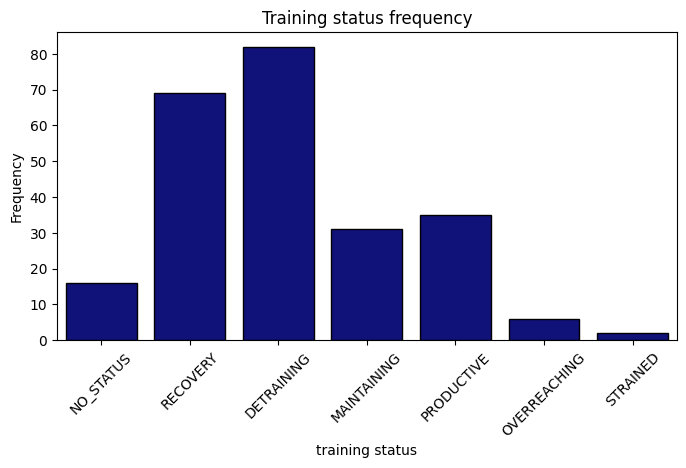

In [32]:
plt.figure(figsize=(8, 4))
sns.countplot(
    x="trainingStatus", data=training_hist, edgecolor="black", color="darkblue"
)
plt.xlabel("training status")
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.title("Training status frequency")
plt.show()

**Grafike** galima pamatyti kaip per visą duomenų imties periodą dažniausiai buvo apibūdinamas treniravimo statusas - RECOVERY (69 kartai) ir DETARAINING (82 kartai). Mažiausiai buvo paminėti STRAINED (2) ir OVERREACHING (6).

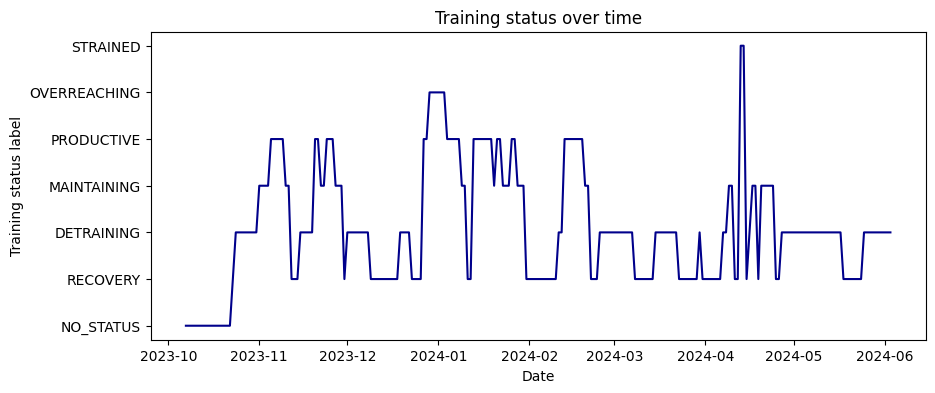

In [33]:
plt.figure(figsize=(10, 4))
plt.plot(
    training_hist["calendarDate"],
    training_hist["trainingStatus"],
    color="darkblue",
)
plt.xlabel("Date")
plt.ylabel("Training status label")
plt.title("Training status over time")
plt.show()

Šis **grafikas** idenfikuoja kaip keičiantis laikui keitėsi treniravimo būklė. Iš grafiko galime aiškiai identifikuoti periodus, kuomet buvo užsiimama sportine veikla ir periodus kuomet ne. 

#### 3.5 Sleep data failas
Šiame faile yra pateikiama visa informacija apie kiekvienos dienos miegą. Iš viso yra 33 skirtingi stulpeliai, tačiau visų nenaudosime. Nereikalingus stulpelius pašaliname ir visas NaN reikšmes paverčiame 0. Kadangi nėra pateikiama visa miego trukmė, jį papildomai išsiskaičiuojam. Garmin laikrodis detektuoja 4 pagrindines stadijas:
- LightSleep (LENGVAS MIEGAS) Pirmoji miego stadija. Akių judesiai ir raumenų veikla lengvo miego stadijoje sulėtėja, o kūnas ruošiasi giliam miegui.
- DeepSleep (GILUS MIEGAS) Akių ir raumenų judesiai visiškai sustoja. Širdies dažnis ir kvėpavimas sulėtėja. Visuotinai pripažinta, kad gilus miegas yra labai naudingas sveikatai. Pavyzdžiui, jis padeda atsistatyti raumenims.
- DeepSleep (GREITO AKIŲ JUDĖJIMO (REM) STADIJA) REM miegas laikomas paskutiniu miego ciklo etapu. REM miego stadijoje įprasta sapnuoti. Paprastai REM miego stadijos iš pradžių yra trumpos, o nakties eigoje ilgėja. Manoma, kad REM miego stadijos metu smegenys turi galimybę apdoroti ir įsisąmoninti duomenis.
- Awake (PABUDIMAS) Apskritai geriausia, kai miegas nenutrūksta visą naktį arba trumpai pabundama vos keletą kartų.

Kiekvienos nakties įvertį (0–100) galima susieti su individualiomis įžvalgomis, kurios gaunamos iš duomenų apie kasdienį gyvenimo būdą.

https://www.garmin.com/lt-LT/garmin-technology/health-science/sleep-tracking/

In [143]:
sleep.head()

,calendarDate,lowestRespiration,highestRespiration,awakeCount,avgSleepStress,restlessMomentCount,sleepScores_overallScore,sleepScores_feedback,sleepScores_insight,previous_day_deep_min,previous_day_light_min,previous_day_rem_min,previous_day_awake_min,previous_day_unmeasurable_min,previous_day_averageRespiration,previous_day_sleepScores_overallScore,previous_day_total_min,previous_day_restlessMomentCount,previous_day_avgSleepStress,previous_day_awakeCount,previous_day_lowestRespiration,previous_day_highestRespiration,new_sleepScores_insight,new_sleepScores_feedback
2,2023-10-05,8.0,15.0,2.0,17.68,13.0,68.0,POSITIVE_SHORT_BUT_REFRESHING,NONE,26.0,102.0,89.0,0.0,0.0,13.0,47.0,217.0,14.0,16.50,0.0,9.0,15.0,NEUTRAL,POSITIVE
3,2023-10-06,11.0,24.0,1.0,51.75,34.0,38.0,NEGATIVE_SHORT_AND_POOR_QUALITY,NONE,44.0,196.0,88.0,19.0,0.0,11.0,68.0,347.0,13.0,17.68,2.0,8.0,15.0,NEUTRAL,NEGATIVE
4,2023-10-07,11.0,17.0,0.0,13.75,23.0,79.0,NEGATIVE_LONG_BUT_NOT_ENOUGH_REM,NONE,73.0,245.0,0.0,14.0,0.0,15.0,38.0,332.0,34.0,51.75,1.0,11.0,24.0,NEUTRAL,NEGATIVE
5,2023-10-08,12.0,17.0,0.0,15.34,19.0,76.0,POSITIVE_DEEP,POSITIVE_LATE_BED_TIME,61.0,324.0,45.0,0.0,0.0,14.0,79.0,430.0,23.0,13.75,0.0,11.0,17.0,POSITIVE_LATE,POSITIVE
6,2023-10-09,9.0,17.0,0.0,11.25,21.0,72.0,POSITIVE_CONTINUOUS,NONE,87.0,208.0,71.0,0.0,0.0,14.0,76.0,366.0,19.0,15.34,0.0,12.0,17.0,NEUTRAL,POSITIVE


In [34]:
sleep = sleep.drop(
    columns=[
        "spo2SleepSummary_sleepMeasurementStartGMT",
        "spo2SleepSummary_sleepMeasurementEndGMT",
        "spo2SleepSummary_averageSPO2",
        "spo2SleepSummary_averageHR",
        "spo2SleepSummary_lowestSPO2",
        "sleepScores_qualityScore",
        "sleepScores_durationScore",
        "sleepScores_recoveryScore",
        "sleepScores_deepScore",
        "sleepScores_remScore",
        "sleepScores_lightScore",
        "sleepScores_awakeningsCountScore",
        "sleepScores_awakeTimeScore",
        "sleepScores_combinedAwakeScore",
        "sleepScores_restfulnessScore",
        "sleepScores_interruptionsScore",
        "sleepStartTimestampGMT",
        "sleepEndTimestampGMT",
    ]
)

In [35]:
sleep_seconds = [
    "deepSleepSeconds",
    "lightSleepSeconds",
    "remSleepSeconds",
    "awakeSleepSeconds",
    "unmeasurableSeconds",
]

# sekundziu informacija pasiverciam minutem
for column_name in sleep.columns:
    if column_name in sleep_seconds:
        sleep[column_name].fillna(0, inplace=True)
        sleep[column_name] = sleep[column_name] / 60

C:\Users\juuus\AppData\Local\Temp\ipykernel_14620\314758336.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sleep[column_name].fillna(0, inplace=True)


In [36]:
# susitvarkom pavadinimus ir visa miego laika susirandam minutem
sleep = sleep.rename(
    columns={
        "deepSleepSeconds": "deep_min",
        "lightSleepSeconds": "light_min",
        "remSleepSeconds": "rem_min",
        "awakeSleepSeconds": "awake_min",
        "unmeasurableSeconds": "unmeasurable_min",
    }
)
sleep["total_min"] = (
    sleep["deep_min"] + sleep["light_min"] + sleep["rem_min"] + sleep["awake_min"]
)

In [37]:
# prisidedam duomenu uz praejusias dienas
def add_previous_day_result(df):
    """
    funkcija prie paduoto df prideda praejusios dienos rezultatus pasirinktiems stulpeliams
    :pram df: Dataframe, kuriame bus tikrinami stulpeliai
    :return: Df su pridetomis naujomis reiksmemis
    """
    columns_needed = [
        "deep_min",
        "light_min",
        "rem_min",
        "awake_min",
        "unmeasurable_min",
        "averageRespiration",
        "sleepScores_overallScore",
        "total_min",
        "restlessMomentCount",
        "avgSleepStress",
        "awakeCount",
        "lowestRespiration",
        "highestRespiration",
    ]

    for column_name in columns_needed:
        if column_name in df.columns:
            df[f"previous_day_{column_name}"] = df[column_name].shift(1)
    return df


sleep = add_previous_day_result(sleep)

In [38]:
# ismetam duomenis, kur nebuvo ivertinta miego kokybe
sleep = sleep.dropna(
    subset=["previous_day_sleepScores_overallScore", "sleepScores_overallScore"]
)
sleep[sleep.isnull().any(axis=1)]

,calendarDate,deep_min,light_min,rem_min,awake_min,unmeasurable_min,averageRespiration,lowestRespiration,highestRespiration,awakeCount,avgSleepStress,restlessMomentCount,sleepScores_overallScore,sleepScores_feedback,sleepScores_insight,total_min,previous_day_deep_min,previous_day_light_min,previous_day_rem_min,previous_day_awake_min,previous_day_unmeasurable_min,previous_day_averageRespiration,previous_day_sleepScores_overallScore,previous_day_total_min,previous_day_restlessMomentCount,previous_day_avgSleepStress,previous_day_awakeCount,previous_day_lowestRespiration,previous_day_highestRespiration


In [39]:
# susiskirtom kategorijom miego insights
sleepScores_insight_mapping = {
    "NONE": "NEUTRAL",
    "POSITIVE_LATE_BED_TIME": "POSITIVE_LATE",
    "NEGATIVE_STRESSFUL_DAY": "NEGATIVE_STRESSFUL",
    "NEGATIVE_LATE_BED_TIME": "NEGATIVE_LATE",
    "POSITIVE_RESTFUL_DAY": "POSITIVE_RESTFUL",
    "NEGATIVE_STRENUOUS_EXERCISE": "NEGATIVE_EXERCISE",
    "NEGATIVE_HIGHLY_STRESSFUL_DAY": "NEGATIVE_STRESSFUL",
    "POSITIVE_EXERCISE": "POSITIVE_EXERCISE",
    "NEGATIVE_LATE_STRENUOUS_EXERCISE": "NEGATIVE_EXERCISE",
    "POSITIVE_STRESSFUL_DAY": "POSITIVE_STRESSFUL",
    "NEGATIVE_VERY_STRENUOUS_EXERCISE": "NEGATIVE_EXERCISE",
    "POSITIVE_RESTFUL_EVENING": "POSITIVE_RESTFUL",
}

sleep["new_sleepScores_insight"] = sleep["sleepScores_insight"].map(
    sleepScores_insight_mapping
)

In [40]:
# susiskirstom miego feedback kategorijom
def return_first_word(column_value):
    return column_value.split("_")[0]


sleep["new_sleepScores_feedback"] = sleep["sleepScores_feedback"].map(return_first_word)

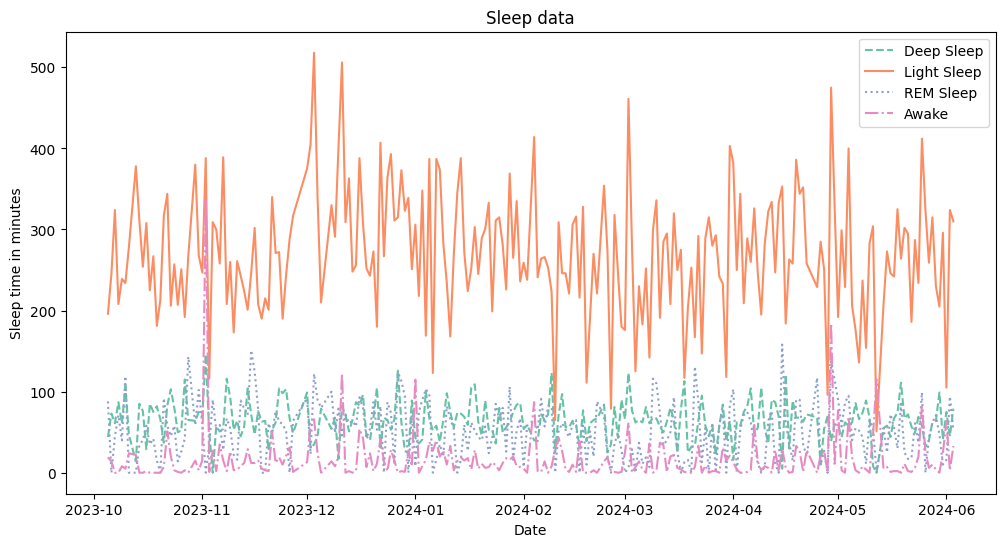

In [41]:
colormap = cm.Set2.colors
plt.figure(figsize=(12, 6))
plt.plot(
    sleep["calendarDate"],
    sleep["deep_min"],
    linestyle="dashed",
    label="Deep Sleep",
    color=colormap[0],
)
plt.plot(
    sleep["calendarDate"],
    sleep["light_min"],
    linestyle="solid",
    label="Light Sleep",
    color=colormap[1],
)
plt.plot(
    sleep["calendarDate"],
    sleep["rem_min"],
    linestyle="dotted",
    label="REM Sleep",
    color=colormap[2],
)

plt.plot(
    sleep["calendarDate"],
    sleep["awake_min"],
    linestyle="dashdot",
    label="Awake",
    color=colormap[3],
)
plt.xlabel("Date")
plt.ylabel("Sleep time in minutes")
plt.title("Sleep data")
plt.legend()
plt.show()

In [42]:
# identifikuojame didziausia outlier
sleep[sleep["awake_min"] > 300]

,calendarDate,deep_min,light_min,rem_min,awake_min,unmeasurable_min,averageRespiration,lowestRespiration,highestRespiration,awakeCount,avgSleepStress,restlessMomentCount,sleepScores_overallScore,sleepScores_feedback,sleepScores_insight,total_min,previous_day_deep_min,previous_day_light_min,previous_day_rem_min,previous_day_awake_min,previous_day_unmeasurable_min,previous_day_averageRespiration,previous_day_sleepScores_overallScore,previous_day_total_min,previous_day_restlessMomentCount,previous_day_avgSleepStress,previous_day_awakeCount,previous_day_lowestRespiration,previous_day_highestRespiration,new_sleepScores_insight,new_sleepScores_feedback
28,2023-11-02,146.0,388.0,0.0,336.0,0.0,13.0,9.0,16.0,6.0,0.0,65.0,45.0,NEGATIVE_LONG_BUT_POOR_QUALITY,NEGATIVE_STRENUOUS_EXERCISE,870.0,69.0,247.0,61.0,15.0,0.0,14.0,48.0,392.0,19.0,38.599998,1.0,10.0,16.0,NEGATIVE_EXERCISE,NEGATIVE


In [43]:
sleep[sleep["awake_min"] > 100]

,calendarDate,deep_min,light_min,rem_min,awake_min,unmeasurable_min,averageRespiration,lowestRespiration,highestRespiration,awakeCount,avgSleepStress,restlessMomentCount,sleepScores_overallScore,sleepScores_feedback,sleepScores_insight,total_min,previous_day_deep_min,previous_day_light_min,previous_day_rem_min,previous_day_awake_min,previous_day_unmeasurable_min,previous_day_averageRespiration,previous_day_sleepScores_overallScore,previous_day_total_min,previous_day_restlessMomentCount,previous_day_avgSleepStress,previous_day_awakeCount,previous_day_lowestRespiration,previous_day_highestRespiration,new_sleepScores_insight,new_sleepScores_feedback
28,2023-11-02,146.0,388.0,0.0,336.0,0.0,13.0,9.0,16.0,6.0,0.000000,65.0,45.0,NEGATIVE_LONG_BUT_POOR_QUALITY,NEGATIVE_STRENUOUS_EXERCISE,870.0,69.0,247.0,61.0,15.0,0.0,14.0,48.0,392.0,19.0,38.599998,1.0,10.0,16.0,NEGATIVE_EXERCISE,NEGATIVE
64,2023-12-11,82.0,506.0,46.0,122.0,0.0,14.0,9.0,23.0,5.0,58.240002,33.0,37.0,NEGATIVE_LONG_BUT_NOT_RESTORATIVE,NEGATIVE_HIGHLY_STRESSFUL_DAY,756.0,17.0,402.0,79.0,20.0,12.0,13.0,68.0,518.0,34.0,24.350000,1.0,9.0,18.0,NEGATIVE_STRESSFUL,NEGATIVE
85,2024-01-01,43.0,306.0,8.0,117.0,0.0,16.0,12.0,21.0,1.0,76.440002,13.0,38.0,NEGATIVE_NOT_RESTORATIVE,NEGATIVE_HIGHLY_STRESSFUL_DAY,474.0,89.0,251.0,71.0,8.0,40.0,11.0,80.0,419.0,27.0,14.360000,1.0,9.0,14.0,NEGATIVE_STRESSFUL,NEGATIVE
202,2024-04-29,39.0,475.0,137.0,184.0,0.0,13.0,9.0,17.0,6.0,23.379999,55.0,52.0,NEGATIVE_LONG_BUT_POOR_QUALITY,NONE,835.0,70.0,96.0,0.0,0.0,0.0,13.0,21.0,166.0,7.0,31.270000,0.0,8.0,16.0,NEUTRAL,NEGATIVE
215,2024-05-12,0.0,51.0,0.0,115.0,0.0,13.0,10.0,15.0,1.0,39.660000,9.0,12.0,NEGATIVE_SHORT_AND_POOR_QUALITY,NONE,166.0,8.0,304.0,56.0,46.0,0.0,12.0,42.0,414.0,19.0,45.310001,2.0,9.0,16.0,NEUTRAL,NEGATIVE


In [44]:
sleep = sleep.drop(
    columns=[
        "deep_min",
        "light_min",
        "rem_min",
        "awake_min",
        "unmeasurable_min",
        "averageRespiration",
        "total_min",
    ]
)

**Grafikas** vaizduoja kaip per laiką keitėsi gilaus, lengvo ir REM miego minutės. Iš grafiko aiškiai matome, kad per visą laiko periodą daugiausiai varijuoja lengvo miego minutės. Didžiausi rezultatai fiksuojami 500-400 minučių intervale per naktį. REM ir gilaus miego rezultatai varijuoja nuo 0 iki 150 minučių per naktį. Violetinė linija vaizduoja pabudimo laiką per naktį. Matome keletą rezultatų, kuomet fiksuojamas itin ilgas laikas virš 300 minučių pabudus per naktį (2023-11-02)

#### 3.6 Activities data failo susitvarkymas
Activities faile yra pateikiama informacija apie visas užfiksuotas sportines veiklas per duomenų imties periodą. Tokių duomenų yra 60. Šioje lentelėje nesifokusuosime į veiklos tipą, pagrindiniai naudojami duomenys bus Distance (Atstumas), Calories (Sudegintos kalorijos) Avg ir Max HR (Širdies ritmo rezultatai sportinės veiklos metu).

In [142]:
activities.head()

,Activity Type,calendarDate,Distance,Calories,Time,Avg HR,Max HR,Weekday
0,Walking,2024-05-18,8.25,562.0,02:19:07,97.0,129.0,Saturday
1,Running,2024-04-20,3.05,232.0,00:20:44,168.0,189.0,Saturday
2,Running,2024-04-17,3.36,266.0,00:22:55,167.0,193.0,Wednesday
3,Running,2024-04-09,3.02,240.0,00:20:50,174.0,195.0,Tuesday
4,Walking,2024-03-31,10.77,681.0,02:25:37,107.0,141.0,Sunday


In [45]:
activities["Weekday"] = activities["calendarDate"].dt.day_name()
activities["calendarDate"] = activities["calendarDate"].dt.date

In [46]:
activities = activities[
    [
        "Activity Type",
        "calendarDate",
        "Distance",
        "Calories",
        "Time",
        "Avg HR",
        "Max HR",
        "Weekday",
    ]
]

In [47]:
activities.replace("--", float("NaN"), inplace=True)
activities = activities.dropna(how="all")
activities["Calories"] = activities["Calories"].str.replace(",", "").astype(float)

In [48]:
activities_by_dates = (
    activities.groupby(["calendarDate"])
    .agg({"Distance": "sum", "Calories": "sum", "Avg HR": "median", "Max HR": "max"})
    .reset_index()
)

activities_by_dates = activities_by_dates.rename(
    columns={
        "Distance": "Activity_Distance",
        "Calories": "Activity_Calories",
        "Avg HR": "Activity_Avg_HR",
        "Max HR": "Activity_Max_HR",
    }
)

activities_by_dates["calendarDate"] = pd.to_datetime(
    activities_by_dates["calendarDate"]
)

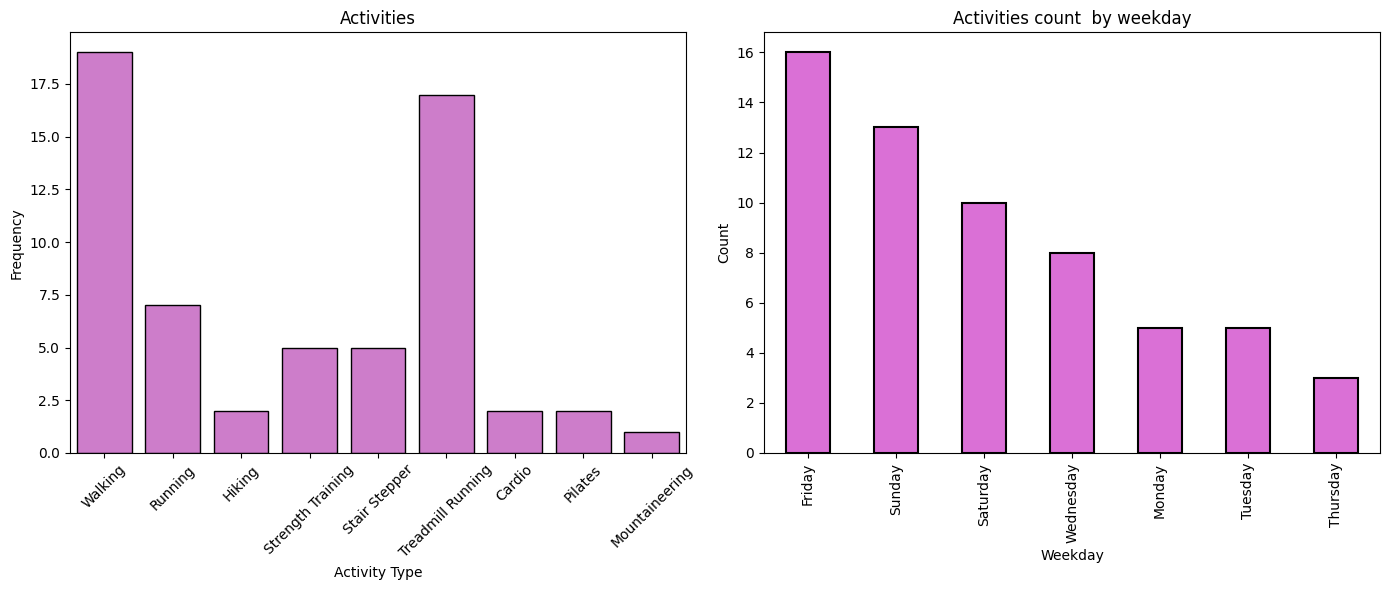

In [49]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

sns.countplot(
    x="Activity Type", data=activities, color="orchid", edgecolor="black", ax=ax1
)
ax1.set_xlabel("Activity Type")
ax1.set_ylabel("Frequency")
ax1.set_title("Activities")
ax1.tick_params(axis="x", rotation=45)

weekdays_act = (
    activities.groupby("Weekday")["Activity Type"].count().sort_values(ascending=False)
)

weekdays_act.plot(kind="bar", linewidth=1.5, color="orchid", edgecolor="black")
ax2.set_xlabel("Weekday")
ax2.set_ylabel("Count")
ax2.set_title("Activities count  by weekday")

plt.tight_layout()
plt.show()

Iš šių **grafikų** galima nustatyti, kurio tipo sportine veikla buvo užsiimama daugiausiai ir kuriomis savaitės dienomis dažniausiai. 
Daugiausiai užfiksuota Walking (Ėjimas) ir Treadmill Running (Bėgimas bėgtakiu) veiklų. Didžiausias aktyvumas pagal savaitės dienas atitinkamai užfiksuotas Penktadieniais, Sekmadieniais ir Šeštadieniais.

#### 3.7 USDfile failo susitvarkymas 
USDfile pateikia bendra informacija apie dienos veiklas:
- Kalorijos;
- Žingsniai;
- Nueitas atstumas;
- Aktyvumo minutės;
- Užlipti aukštai aukštai ir žemyn (vienas aukštas vidutiniškai yra 3 metrai);
- Širdies ritmas ramybės būsenoje;
- "BodyBattery" informacija;
- Streso informacija.

In [144]:
usdfile.head()

,calendarDate,totalKilocalories,activeKilocalories,totalSteps,totalDistanceMeters,highlyActiveSeconds,activeSeconds,moderateIntensityMinutes,floor_up,floor_down,restingHeartRate,bodyBattery.chargedValue,bodyBattery.drainedValue,TOTALaverageStressLevel,TOTALmaxStressLevel,TOTALstressDuration,TOTALrestDuration,HIGHESTstatsValue,LOWESTstatsValue,Weekday
0,2023-10-02,1806.0,0.0,60,45,0,257,0,0.000000,0.000000,45.0,22,0,3,36.0,60.0,3780.0,55,33,Monday
1,2023-10-03,2075.0,269.0,10068,7667,3130,5813,0,23.829667,12.920333,47.0,63,69,23,90.0,25920.0,41640.0,100,45,Tuesday
2,2023-10-04,2160.0,354.0,12533,9546,4094,7622,0,16.256000,16.887333,48.0,30,59,29,92.0,29880.0,41400.0,77,20,Wednesday
3,2023-10-05,2015.0,209.0,8663,6554,3841,4456,0,10.160000,14.178667,48.0,59,59,25,90.0,20160.0,53100.0,71,19,Thursday
4,2023-10-06,2343.0,539.0,4843,3722,3898,4570,17,1.016000,0.000000,49.0,24,35,47,99.0,52920.0,19260.0,21,5,Friday


In [50]:
# usdfile df specifinis tvarkymas
usdfile = usdfile[
    [
        "calendarDate",
        "totalKilocalories",
        "activeKilocalories",
        "totalSteps",
        "totalDistanceMeters",
        "highlyActiveSeconds",
        "activeSeconds",
        "moderateIntensityMinutes",
        "floorsAscendedInMeters",
        "floorsDescendedInMeters",
        "restingHeartRate",
        "bodyBattery.chargedValue",
        "bodyBattery.drainedValue",
        "TOTALaverageStressLevel",
        "TOTALmaxStressLevel",
        "TOTALstressDuration",
        "TOTALrestDuration",
        "HIGHESTstatsValue",
        "LOWESTstatsValue",
    ]
]

In [51]:
floors = ["floorsAscendedInMeters", "floorsDescendedInMeters"]

for column_name in usdfile.columns:
    if column_name in floors:
        usdfile[column_name] = usdfile[column_name] / 3

usdfile = usdfile.rename(
    columns={
        "floorsAscendedInMeters": "floor_up",
        "floorsDescendedInMeters": "floor_down",
    }
)

In [52]:
# pasiziurim kuriomis savaitemis dienomis didziausias aktyvumas
usdfile["Weekday"] = usdfile["calendarDate"].dt.day_name()

weekdays_usdfile = usdfile.groupby("Weekday").agg(
    {
        "totalKilocalories": "mean",
        "activeKilocalories": "mean",
        "totalSteps": "mean",
        "highlyActiveSeconds": "mean",
        "totalDistanceMeters": "mean",
        "TOTALaverageStressLevel": "mean",
        "TOTALmaxStressLevel": "mean",
        "bodyBattery.chargedValue": "mean",
        "bodyBattery.drainedValue": "mean",
        "floor_up": "mean",
        "floor_down": "mean",
    }
)

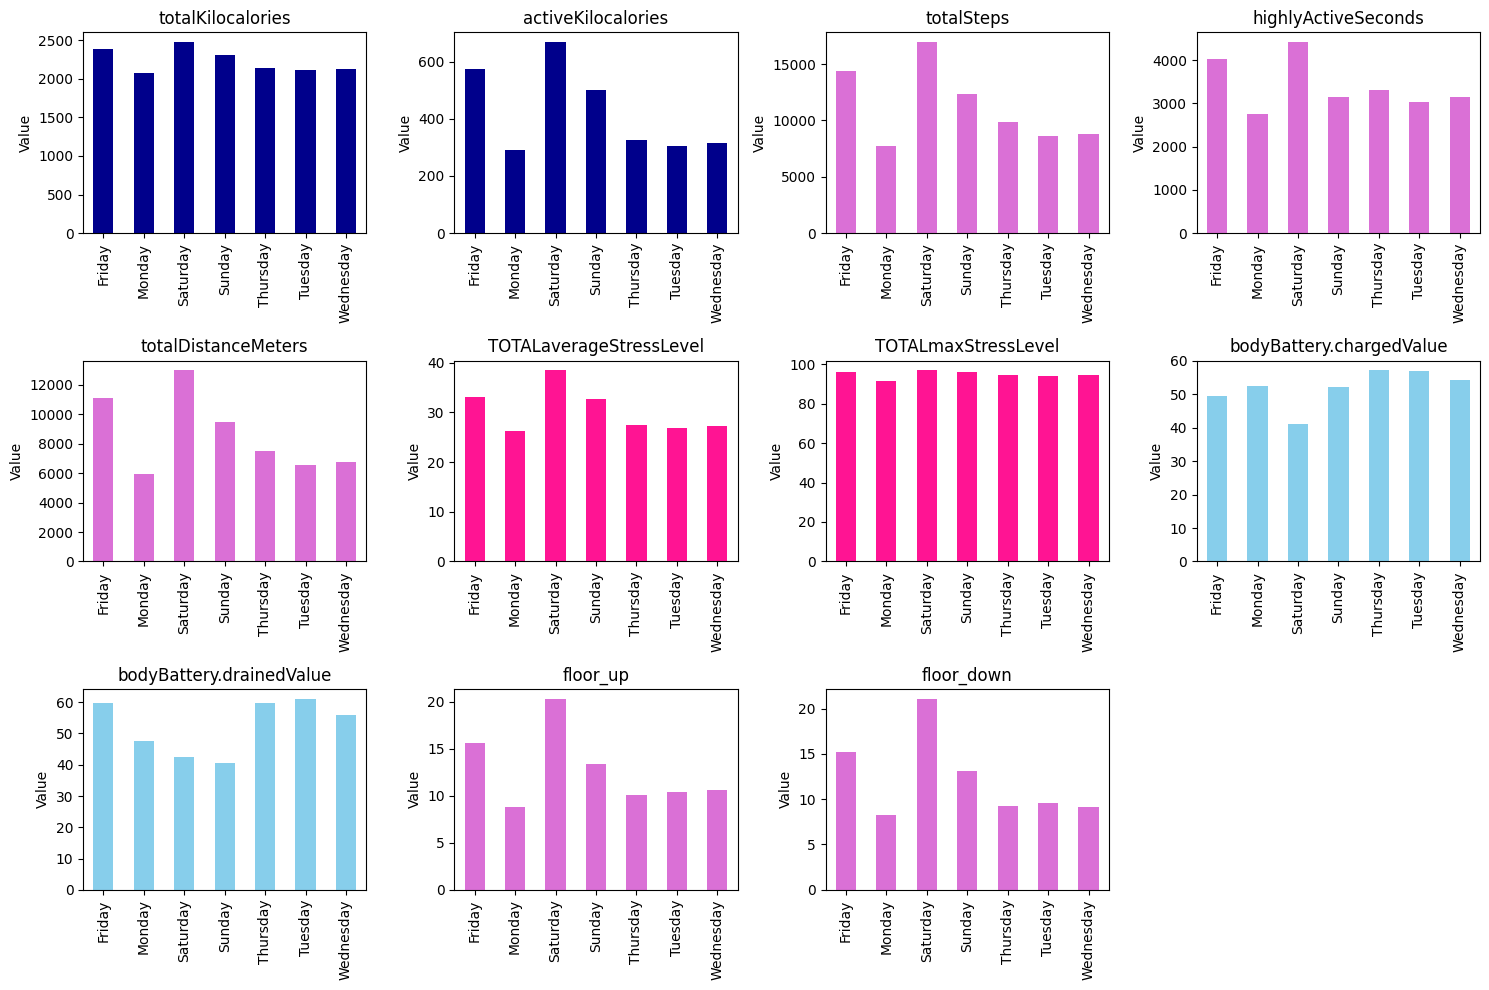

In [53]:
def plot_average_weekdays_results(df):
    """
    Iteruoja per df ir kiekvienam stulpeliui nubraizo priklausomybe pagal savaites diena.
    Parameters:
    :param df: DataFrame.
    :returns: dict: figura su nubraizytais grafikais
    """
    num_plots = len(df.columns)
    fig, axs = plt.subplots(3, 4, figsize=(15, 10))
    axs = axs.flatten()  # Flatten the 2D array of axes for easier iteration
    columns = df.columns

    color_dict = {
        "totalKilocalories": "darkblue",
        "activeKilocalories": "darkblue",
        "totalSteps": "orchid",
        "highlyActiveSeconds": "orchid",
        "totalDistanceMeters": "orchid",
        "TOTALaverageStressLevel": "deeppink",
        "TOTALmaxStressLevel": "deeppink",
        "bodyBattery.chargedValue": "skyblue",
        "bodyBattery.drainedValue": "skyblue",
        "floor_up": "orchid",
        "floor_down": "orchid",
    }

    for i, column_name in enumerate(columns):
        ax = axs[i]
        color = color_dict.get(column_name, None) if color_dict else None
        df[column_name].plot(kind="bar", ax=ax, color=color, linewidth=1.5)
        ax.set_title(column_name)
        ax.set_xlabel("")
        ax.set_ylabel("Value")

    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()


plot_average_weekdays_results(weekdays_usdfile)

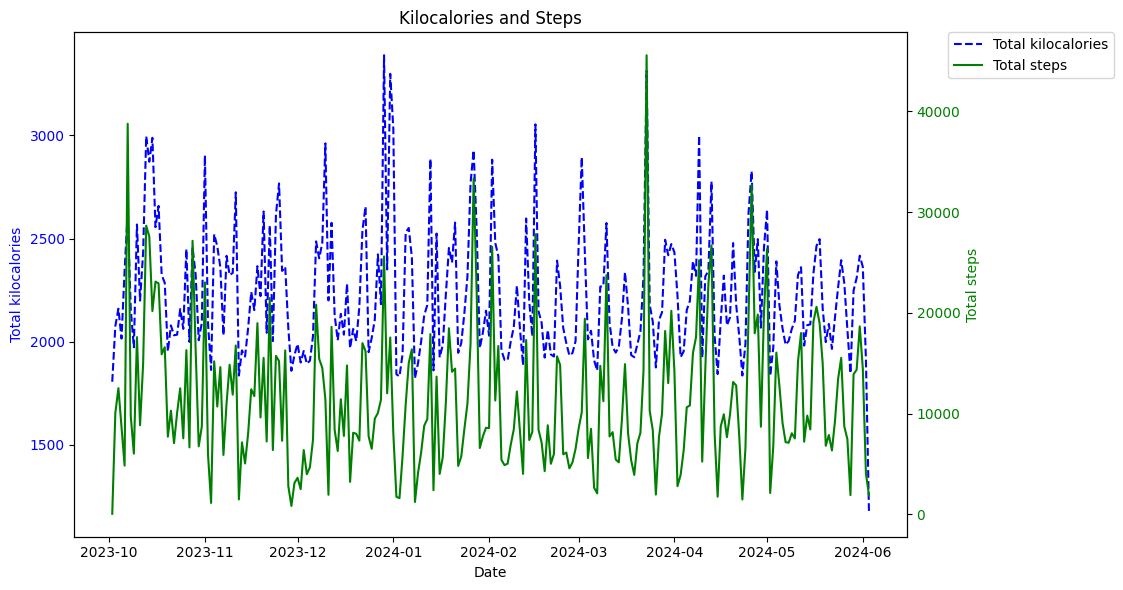

In [54]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()  # Create a twin y-axis for ax1

# Plot total kilocalories on ax1
ax1.plot(
    usdfile["calendarDate"],
    usdfile["totalKilocalories"],
    linestyle="dashed",
    color="b",
    label="Total kilocalories",
)
ax1.set_xlabel("Date")
ax1.set_ylabel("Total kilocalories", color="b")
ax1.tick_params(axis="y", labelcolor="b")

# Plot total steps on ax2
ax2.plot(
    usdfile["calendarDate"],
    usdfile["totalSteps"],
    linestyle="solid",
    color="g",
    label="Total steps",
)
ax2.set_ylabel("Total steps", color="g")
ax2.tick_params(axis="y", labelcolor="g")

# Set title and adjust layout
plt.title("Kilocalories and Steps")
fig.tight_layout()

# Combine legends from ax1 and ax2
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines_1 + lines_2,
    labels_1 + labels_2,
    loc="upper left",
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0.0,
)

plt.show()

**Grafike** matome kalorijų ir nueitų žingsnių priklausomybę per visą duomenų imties periodą. Duomenys pakankamai šokinėja ir matome nemažai smailių, kurios identifikuoja didesnius kalorijų praradimus. Didžiausi kalorijų bei žingsnių skaičiai užfiksuoti 2023-10 mėn ir 2024-03 mėn.

### 4. Visų duomenų sujungimas
Tolimesniai duomenų analizei naudosime vieną bendrą lentelę, kurioje bus visos 3 žingsnyje paminėtos ir parašytos lentelės. Lentelės jungiame pagal datą. Po activities lentelės prijungimo prie visų duomenų nežinomas reikšmes galima užpildyti 0, kadangi iš visų duomenų imties tik 60 dienų turėjo sportines veiklas. 
Po visų duomenų sujungimo idenfikuojame, jog 15 dienų nėra jokių rezultatų apie miego kokybę, darome prielaidą, jog tomis dienomis laikrodis buvo kraunamas ir šiuos duomenis pašaliname. 

In [55]:
# susijungiam visus duomenis
all_data = pd.merge(usdfile, training_hist, on=["calendarDate"], how="outer")
all_data = pd.merge(all_data, all_hydr_act, on=["calendarDate"], how="outer")
all_data = pd.merge(all_data, activities_by_dates, on=["calendarDate"], how="outer")
all_data = all_data.fillna(0)
all_data = pd.merge(all_data, sleep, on=["calendarDate"], how="outer")

In [56]:
all_data[all_data.isnull().any(axis=1)]

,calendarDate,totalKilocalories,activeKilocalories,totalSteps,totalDistanceMeters,highlyActiveSeconds,activeSeconds,moderateIntensityMinutes,floor_up,floor_down,restingHeartRate,bodyBattery.chargedValue,bodyBattery.drainedValue,TOTALaverageStressLevel,TOTALmaxStressLevel,TOTALstressDuration,TOTALrestDuration,HIGHESTstatsValue,LOWESTstatsValue,Weekday,trainingStatus,estimatedSweatLossInML,vo2MaxValue,Activity_Distance,Activity_Calories,Activity_Avg_HR,Activity_Max_HR,lowestRespiration,highestRespiration,awakeCount,avgSleepStress,restlessMomentCount,sleepScores_overallScore,sleepScores_feedback,sleepScores_insight,previous_day_deep_min,previous_day_light_min,previous_day_rem_min,previous_day_awake_min,previous_day_unmeasurable_min,previous_day_averageRespiration,previous_day_sleepScores_overallScore,previous_day_total_min,previous_day_restlessMomentCount,previous_day_avgSleepStress,previous_day_awakeCount,previous_day_lowestRespiration,previous_day_highestRespiration,new_sleepScores_insight,new_sleepScores_feedback
0,2023-10-02,1806.0,0.0,60,45,0,257,0,0.000000,0.000000,45.0,22,0,3,36.0,60.0,3780.0,55,33,Monday,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-10-03,2075.0,269.0,10068,7667,3130,5813,0,23.829667,12.920333,47.0,63,69,23,90.0,25920.0,41640.0,100,45,Tuesday,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-10-04,2160.0,354.0,12533,9546,4094,7622,0,16.256000,16.887333,48.0,30,59,29,92.0,29880.0,41400.0,77,20,Wednesday,0,0.0,44.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,2023-10-12,2433.0,552.0,14943,11332,2761,12592,0,4.529333,9.440667,52.0,2,62,49,98.0,43920.0,9720.0,65,5,Thursday,NO_STATUS,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,2023-10-29,2325.0,519.0,16348,12367,4639,7065,73,8.470000,8.550333,51.0,10,22,45,97.0,31620.0,6060.0,27,5,Sunday,DETRAINING,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,2023-11-28,2067.0,333.0,2814,2129,205,3056,14,1.262000,0.000000,51.0,9,18,64,99.0,67320.0,7080.0,14,5,Tuesday,MAINTAINING,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,2023-11-29,1859.0,53.0,841,637,255,1637,0,0.000000,0.000000,52.0,12,36,41,92.0,28500.0,11220.0,41,14,Wednesday,MAINTAINING,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,2023-11-30,1936.0,130.0,3131,2369,1056,1696,0,0.000000,3.519333,52.0,89,60,25,97.0,25860.0,52140.0,90,17,Thursday,RECOVERY,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,2023-12-06,2028.0,222.0,7434,5624,2661,3128,0,5.328333,8.770000,49.0,6,53,28,94.0,22140.0,28200.0,76,25,Wednesday,DETRAINING,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,2023-12-07,2486.0,605.0,20820,15750,2553,12904,0,21.536333,17.456667,49.0,35,59,39,97.0,39540.0,21960.0,57,5,Thursday,DETRAINING,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
all_data = all_data.dropna()

In [58]:
all_data.isna().sum()

calendarDate                             0
totalKilocalories                        0
activeKilocalories                       0
totalSteps                               0
totalDistanceMeters                      0
highlyActiveSeconds                      0
activeSeconds                            0
moderateIntensityMinutes                 0
floor_up                                 0
floor_down                               0
restingHeartRate                         0
bodyBattery.chargedValue                 0
bodyBattery.drainedValue                 0
TOTALaverageStressLevel                  0
TOTALmaxStressLevel                      0
TOTALstressDuration                      0
TOTALrestDuration                        0
HIGHESTstatsValue                        0
LOWESTstatsValue                         0
Weekday                                  0
trainingStatus                           0
estimatedSweatLossInML                   0
vo2MaxValue                              0
Activity_Di

In [59]:
avg_all_data = all_data.describe()

In [60]:
# pasitikrinam ar nera outliers tikslineje verteje
z = np.abs(stats.zscore(all_data["sleepScores_overallScore"]))
threshold = 3
outliers_sleep = all_data[z > threshold]
outliers_sleep

,calendarDate,totalKilocalories,activeKilocalories,totalSteps,totalDistanceMeters,highlyActiveSeconds,activeSeconds,moderateIntensityMinutes,floor_up,floor_down,restingHeartRate,bodyBattery.chargedValue,bodyBattery.drainedValue,TOTALaverageStressLevel,TOTALmaxStressLevel,TOTALstressDuration,TOTALrestDuration,HIGHESTstatsValue,LOWESTstatsValue,Weekday,trainingStatus,estimatedSweatLossInML,vo2MaxValue,Activity_Distance,Activity_Calories,Activity_Avg_HR,Activity_Max_HR,lowestRespiration,highestRespiration,awakeCount,avgSleepStress,restlessMomentCount,sleepScores_overallScore,sleepScores_feedback,sleepScores_insight,previous_day_deep_min,previous_day_light_min,previous_day_rem_min,previous_day_awake_min,previous_day_unmeasurable_min,previous_day_averageRespiration,previous_day_sleepScores_overallScore,previous_day_total_min,previous_day_restlessMomentCount,previous_day_avgSleepStress,previous_day_awakeCount,previous_day_lowestRespiration,previous_day_highestRespiration,new_sleepScores_insight,new_sleepScores_feedback


### 5. Duomenų koreliacija
Prieš pradedant modelio kūrimą pasitikriname kaip naudojami duomenys koreliuoja su miego įvertinimo balu. 

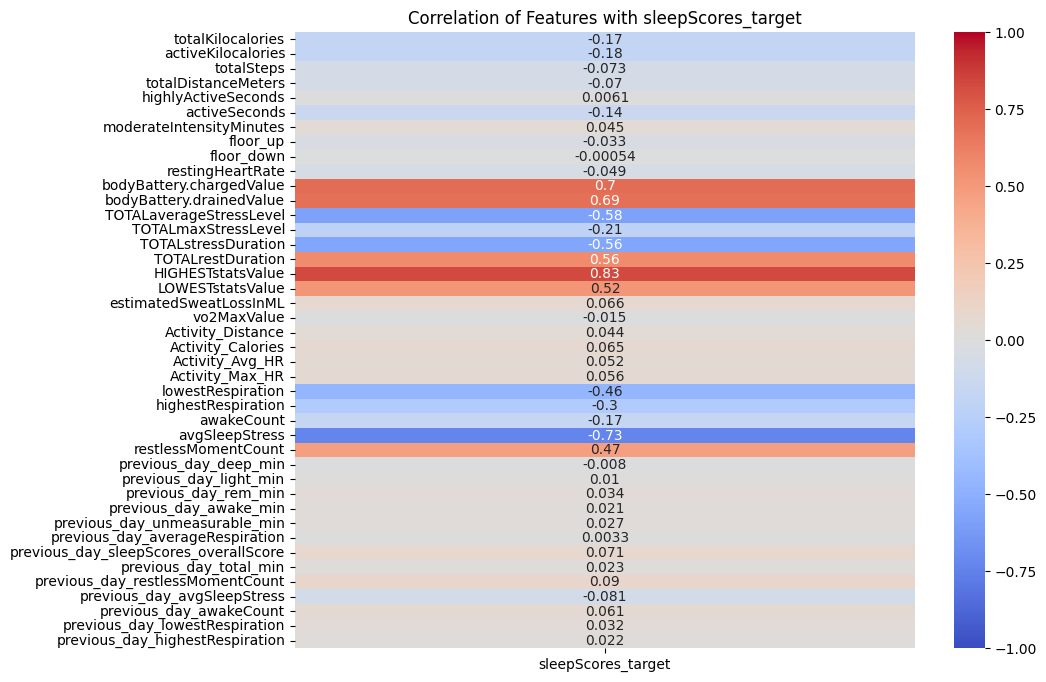

In [61]:
corre_all_data = all_data.drop(
    columns=[
        "calendarDate",
        "new_sleepScores_feedback",
        "new_sleepScores_insight",
        "Weekday",
        "sleepScores_overallScore",
        "trainingStatus",
        "sleepScores_feedback",
        "sleepScores_insight",
    ]
)
corre_all_data["sleepScores_target"] = all_data["sleepScores_overallScore"]

# Calculate the correlation matrix
target_variable = "sleepScores_target"
correlation_matrix = corre_all_data.corr()

# Extract the correlations with the target variable
target_corr = correlation_matrix[[target_variable]].drop(target_variable)

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(target_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, cbar=True)
plt.title(f"Correlation of Features with {target_variable}")
plt.show()

Iš koreliacijos **grafiko** galima nustatyti, jog didžiausią neigiamą įtaką tiksliniam miego įverčiui turi stresas. 
Didžiausia koreliacija matoma su "BodyBattery" duomenimis.

### 6. Duomenų paruošimas modelio kūrimui
Naudojantis formule iš duomenų pašalinami visi duomenys, kurie su tiksline verte koreliuoja daugiau nei 0.7. 
Modelių kūrimui, testavimui bei mokymui bus naudojami 231 duomenys. 

In [62]:
def drop_highly_correlated_features(df, target_column, n_value):
    """
    ismeta reiksmes is visu duomenu imties, kurios korealiuoja daugiau nei nurodyta reiksme
    :pram df: Dataframe, kuriame bus tikrinami stulpeliai
    :pram target_column: tikslines vertes stulpelis, sio stulpelio koreliacija bus tikrinama su viso df
    :pram n_value: korealiacijos reiksmes riba
    :return: sutvarkytas df be reiksmiu, kurios koreliuoja daugiau nei nurodyta funkcijoje
    """
    corr_matrix = df.corr().abs()
    target_corr = corr_matrix[target_column]
    to_drop = [
        column
        for column in target_corr.index
        if (target_corr[column] > n_value) and (column != target_column)
    ]
    df_dropped = df.drop(columns=to_drop)

    return df_dropped


data_w_sleep = drop_highly_correlated_features(
    corre_all_data, target_column="sleepScores_target", n_value=0.7
)

In [63]:
X = data_w_sleep.drop(
    columns=["sleepScores_target", "previous_day_sleepScores_overallScore"],
    axis=1,
)
y = data_w_sleep["sleepScores_target"]

In [64]:
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 7. Modelių kūrimas
Modelių kūrime buvo kuriama keletas skirtingų regresijos modelių. Daugiausiai dėmesio skirta linijinei regresijai, analizuota kaip duomenys apsimoko būtent šiame modelyje. 
Papildomai išbandyta ir keletas klasifikatorių klasifikuojant miegą į teigiamą ir neigiamą, tačiau ties šiais rezultatais nesifokusuosime. 

#### 7.1 Formulės naudojamos modelio efektyvmui patikrinti

In [65]:
def model_effectivness(y_test_data, y_pred_data):
    """
    patikrina koks buvo sukurto modelio efektyvumas
    :pram y_test_data: tikslinė vertė, kurią modelis turi nuspėti
    :pram y_pred_data: tikslinė vertė, kurią ištreniruotas modelis ištikrųjų nuspėjo
    :return: grazinami 4 pagrindiniai rodikliai leidziantys nustatyti sukurto modelio efektyvuma vidutine absoliuti paklaida (MAE),
    vidutine kvadratine paklaida (MSE), saknis is mae (RMSE), R kvadratu (r2)
    """
    mae = mean_absolute_error(y_test_data, y_pred_data)
    mse = mean_squared_error(y_test_data, y_pred_data)
    rmse = root_mean_squared_error(y_test_data, y_pred_data)
    r2 = r2_score(y_test_data, y_pred_data)
    return f"""Mean Absolute Error: {mae}
            Mean Squared Error: {mse}
            Root Mean Squared Error: {rmse}
            R-squared: {r2}"""

In [66]:
def variables_importance(pipeline, data):
    """
    funkcija nustato kaip kiekviena savybe veikia testuojama modeli
    :pram pipeline: pipeline, kuriame yra treniruojamas modelis
    :pram data: duomenys su kuriais dirbama be target reiksmes
    :return: grazina kokia reiksme kiekviena savybe turi modelio tikslumui
    """
    model = pipeline.named_steps["regressor"]
    if hasattr(model, "coef_"):
        coefficients = model.coef_
        features = data.columns
        importance = pd.DataFrame({"Feature": features, "Coefficient": coefficients})
        importance = importance.sort_values(by="Coefficient", ascending=False)
    elif hasattr(model, "feature_importances_"):
        coefficients = model.feature_importances_
        features = data.columns
        importance = pd.DataFrame({"Feature": features, "Coefficient": coefficients})
        importance = importance.sort_values(by="Coefficient", ascending=False)
    return importance

In [67]:
def iterate_over_mistakes(df, comparison_df, mistakes_value):
    """
    patikrina kokias klaidas modelis dare ir jas grazina
    :pram df: originalus df, kuriuo remiantis buvo sukurti duomenu paketai treniravimui ir testavimui
    :pram comparison_df: df sudarytas is tiksliniu verciu is originaliu duomenu, modelio nustatytu verciu ir jo palyginimo
    :pram mistakes_value: klaidos riba, formule grazins visus duomenis kuriu modeliui nepavyko nustatyti per nurodyta riba
    :return: grazinamas df, kuri sudaro duomenys, kur modelis suklydo nustatyti tiksline reiksme daugiau nei per nurodyta mistakes_value reiksme
    """
    mistakes = comparison_df[
        comparison_df["Diff"]
        > mistakes_value | (comparison_df["Diff"] < -mistakes_value)
    ]
    mistakes_df = pd.DataFrame()
    for index in mistakes.index:
        mistakes_df = pd.concat([mistakes_df, df.loc[[index]]])
    return mistakes_df

In [68]:
num_features = X.columns

preprocessor_columns = ColumnTransformer(
    [
        ("int", StandardScaler(), num_features),
    ]
)

#### 7.2 Linijinė regresija

##### 7.2.1 Linijinė regresija

In [69]:
lr_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor_columns),
        ("regressor", LinearRegression()),
    ]
)

In [70]:
lr_pipeline.fit(X1_train, y1_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('int', StandardScaler(),
                                                  Index(['totalKilocalories', 'activeKilocalories', 'totalSteps',
       'totalDistanceMeters', 'highlyActiveSeconds', 'activeSeconds',
       'moderateIntensityMinutes', 'floor_up', 'floor_down',
       'restingHeartRate', 'bodyBattery.chargedValue',
       'bodyBattery.drainedValue', 'TOTALaverageStre...
       'previous_day_light_min', 'previous_day_rem_min',
       'previous_day_awake_min', 'previous_day_unmeasurable_min',
       'previous_day_averageRespiration', 'previous_day_total_min',
       'previous_day_restlessMomentCount', 'previous_day_avgSleepStress',
       'previous_day_awakeCount', 'previous_day_lowestRespiration',
       'previous_day_highestRespiration'],
      dtype='object'))])),
                ('regressor', LinearRegression())])

In [71]:
y1_pred = lr_pipeline.predict(X1_test)

In [72]:
lr_effect = model_effectivness(y1_test, y1_pred)
print(lr_effect)

Mean Absolute Error: 7.802501533993373
            Mean Squared Error: 104.74589373167841
            Root Mean Squared Error: 10.234544138928632
            R-squared: 0.6000392741889982


Vidutinė absoliuti paklaida (MAE) indikuoja, jog ištreniruoto modelio prognozės vidutiniškai skiriasi per 7.80 nuo tikrųjų reikšmių.    
Vidutinė kvadratinių klaidų reikšmė 104.74 (MSE) reikšmė yra lygi modelio klaidos kvadratui. Didesnės klaidos turi didesnę reikšmę šiam dydžiui.  
Kvadratinė absoliučioji paklaida (RMSE) indikuoja, jog dažniausiai modelis suklystas per 10.23. RMSE rodo, kiek vidutiniškai modelio prognozės skiriasi nuo tikrųjų vertybių, vertinant tą pačią skalę kaip ir originalūs duomenys.  
R² (0.60) indikuoja, jog modelis 60% visų duomenų interpretuoja tinkamai.  
Modelis turi vidutinio lygio tikslumą, tačiau yra šiek tiek jautrus didelėms klaidoms ką parodo RMSE ir MSE dydžiai.

In [73]:
predict_compare = pd.DataFrame(
    {"Predicted": y1_pred, "Actual": y1_test, "Diff": (y1_test - y1_pred)}
)
predict_compare = predict_compare.sort_values(by="Diff", ascending=False)

In [145]:
linear_variables_importance = variables_importance(lr_pipeline, X)
linear_variables_importance

,Feature,Coefficient
10,bodyBattery.chargedValue,7.904143
1,activeKilocalories,7.099391
3,totalDistanceMeters,6.580139
26,restlessMomentCount,6.055068
11,bodyBattery.drainedValue,5.458636
16,LOWESTstatsValue,4.642853
22,Activity_Max_HR,2.938230
8,floor_down,2.519158
5,activeSeconds,2.225820
38,previous_day_highestRespiration,2.033187


Variables importance interpretavimas:  
Teigimas koeficientas: Padidėjus savybės reikšmei padidėja ir tikslinės vertės reikšmė, įtaka teigiama.  
Neigiamas koeficientas: Padidėjus savybės reikšmei sumažėja tikslinės vertės reikšmė, įtaka neigiama. 

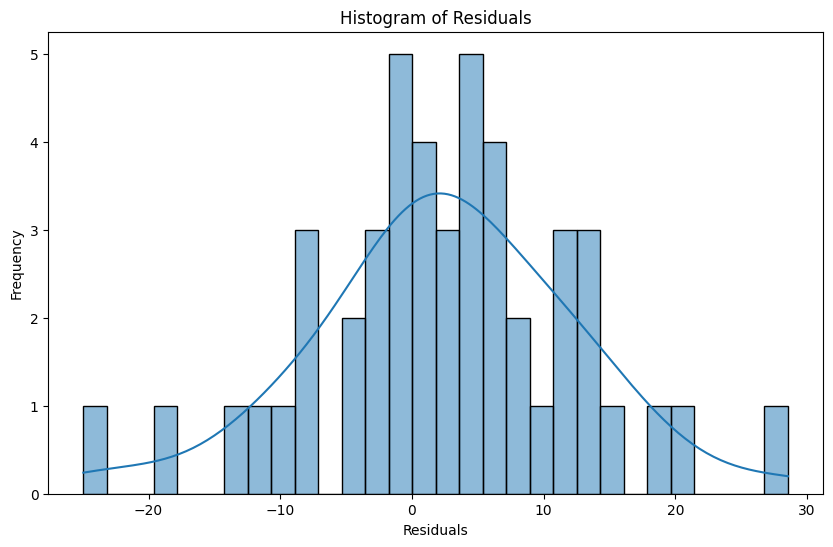

In [75]:
plt.figure(figsize=(10, 6))
sns.histplot(predict_compare["Diff"], bins=30, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

**Grafike** vaizudojamos modelio klaidų pasiskirstymas. Matoma, kad yra pavienių rezultatų kur modelis suklysta +-20 punktų, tačiau didžioji dalis visų klaidų yra pasiskirsčiusi intervale [-10; 10]. Paklaidų maksimumas yra 5.

In [76]:
mistakes_over10 = iterate_over_mistakes(corre_all_data, predict_compare, 10)

##### 7.2.1 Linijinė regresija su patobulintais duomenimis
3.5 punkte identifikuoti duomenys, kuriuose miego rezultatas labai išsiskiria is kitų, tai yra buvo užfiksuotas ilgiausias laikas prabudus. Pašalinus šiuos duomenis, stebėsime ar modelio tikslumas bus pagerintas.

In [77]:
all_data_improved = all_data[all_data["calendarDate"] != "2023-11-02"]
# all_data_improved = all_data[all_data["calendarDate"] != "2024-04-29"]

In [78]:
all_data_improved = all_data_improved.drop(
    columns=[
        "calendarDate",
        "Weekday",
        "trainingStatus",
        "sleepScores_feedback",
        "sleepScores_insight",
        "new_sleepScores_insight",
        "new_sleepScores_feedback",
        "previous_day_sleepScores_overallScore",
    ]
)

In [79]:
all_data_improved = drop_highly_correlated_features(
    all_data_improved, target_column="sleepScores_overallScore", n_value=0.7
)

In [80]:
X_imp = all_data_improved.drop(
    columns=[
        "sleepScores_overallScore",
    ],
    axis=1,
)
y_imp = all_data_improved["sleepScores_overallScore"]

In [81]:
Ximp_train, Ximp_test, yimp_train, yimp_test = train_test_split(
    X_imp, y_imp, test_size=0.2, random_state=42
)

In [82]:
num_features1 = X_imp.columns

preprocessor_columns1 = ColumnTransformer(
    [
        ("int", StandardScaler(), num_features1),
    ]
)

lr_pipeline1 = Pipeline(
    steps=[
        ("preprocessor", preprocessor_columns1),
        ("regressor", LinearRegression()),
    ]
)

In [83]:
lr_pipeline1.fit(Ximp_train, yimp_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('int', StandardScaler(),
                                                  Index(['totalKilocalories', 'activeKilocalories', 'totalSteps',
       'totalDistanceMeters', 'highlyActiveSeconds', 'activeSeconds',
       'moderateIntensityMinutes', 'floor_up', 'floor_down',
       'restingHeartRate', 'bodyBattery.chargedValue',
       'bodyBattery.drainedValue', 'TOTALaverageStre...
       'previous_day_light_min', 'previous_day_rem_min',
       'previous_day_awake_min', 'previous_day_unmeasurable_min',
       'previous_day_averageRespiration', 'previous_day_total_min',
       'previous_day_restlessMomentCount', 'previous_day_avgSleepStress',
       'previous_day_awakeCount', 'previous_day_lowestRespiration',
       'previous_day_highestRespiration'],
      dtype='object'))])),
                ('regressor', LinearRegression())])

In [84]:
yimp_pred = lr_pipeline1.predict(Ximp_test)

In [85]:
lr_effect1 = model_effectivness(yimp_test, yimp_pred)
print(lr_effect1)

Mean Absolute Error: 7.372313308001518
            Mean Squared Error: 79.4346438588251
            Root Mean Squared Error: 8.912611506108918
            R-squared: 0.7234323603901053


Ištreniruoto modelio prognozės vidutiniškai skiriasi per 7.37 nuo tikrųjų reikšmių.  
Vidutinė kvadratinių klaidų reikšmė 79.43 (MSE) reikšmė yra lygi modelio klaidos kvadratui. 
Vidutiniškai modelio prognozės skiriasi nuo tikrųjų vertybių per 8.91 kuomet yra vertinama ta pati skalė kaip ir originalių duomenų.  Modelis paaiškina apie 72.34% duomenų variacijos, kas rodo, kad modelis yra gerokai patikimesnis ir gali geriau paaiškinti duomenų variaciją nei ankstesni rezultatai.  
Sumažėjęs RMSE ir MSE palyginti su ankstesniais rezultatais rodo, jog modelis yra tikslesnis ir patikimesnis.

In [86]:
linear_variables_importance_imprv = variables_importance(lr_pipeline1, X_imp)
linear_variables_importance_imprv.head()

,Feature,Coefficient
10,bodyBattery.chargedValue,7.488043
1,activeKilocalories,6.378163
21,Activity_Avg_HR,6.104974
16,LOWESTstatsValue,5.537603
26,restlessMomentCount,5.380613


In [87]:
predict_compare_imp = pd.DataFrame(
    {"Predicted": yimp_pred, "Actual": yimp_test, "Diff": (yimp_test - yimp_pred)}
)
predict_compare_imp = predict_compare_imp.sort_values(by="Diff", ascending=False)

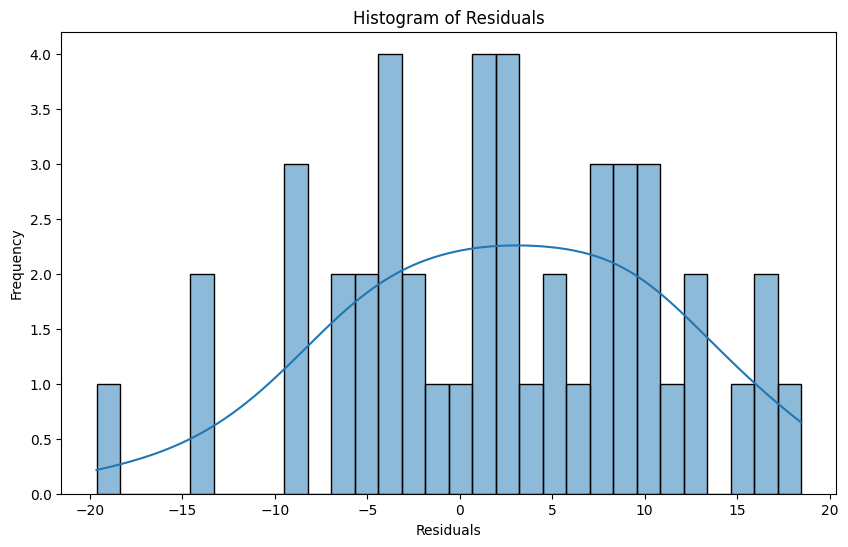

In [88]:
plt.figure(figsize=(10, 6))
sns.histplot(predict_compare_imp["Diff"], bins=30, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

**Grafike** matome paklaidų sumažėjimą, pasikartojamumas sumažėjo iki 4. Daugiau outlier liko minusinėje skalėje.

In [89]:
mistakes_over10_imp = iterate_over_mistakes(all_data_improved, predict_compare_imp, 10)

In [90]:
# palyginam kur abi regresijos dare klaidas vienodai
compared_index = []
for index in mistakes_over10.index:
    if index in mistakes_over10_imp.index:
        compared_index.append(index)
print(compared_index)

[214, 208, 159, 219, 20, 19, 123, 137, 197, 138, 23, 193, 22]


In [91]:
# palyginam kur abi regresijos dare klaidas vienodai
mistaken_data = all_data.loc[all_data.index.isin(compared_index)]
mistaken_data

,calendarDate,totalKilocalories,activeKilocalories,totalSteps,totalDistanceMeters,highlyActiveSeconds,activeSeconds,moderateIntensityMinutes,floor_up,floor_down,restingHeartRate,bodyBattery.chargedValue,bodyBattery.drainedValue,TOTALaverageStressLevel,TOTALmaxStressLevel,TOTALstressDuration,TOTALrestDuration,HIGHESTstatsValue,LOWESTstatsValue,Weekday,trainingStatus,estimatedSweatLossInML,vo2MaxValue,Activity_Distance,Activity_Calories,Activity_Avg_HR,Activity_Max_HR,lowestRespiration,highestRespiration,awakeCount,avgSleepStress,restlessMomentCount,sleepScores_overallScore,sleepScores_feedback,sleepScores_insight,previous_day_deep_min,previous_day_light_min,previous_day_rem_min,previous_day_awake_min,previous_day_unmeasurable_min,previous_day_averageRespiration,previous_day_sleepScores_overallScore,previous_day_total_min,previous_day_restlessMomentCount,previous_day_avgSleepStress,previous_day_awakeCount,previous_day_lowestRespiration,previous_day_highestRespiration,new_sleepScores_insight,new_sleepScores_feedback
19,2023-10-21,2079.0,273.0,10299,7799,3823,3739,18,10.414333,16.890667,56.0,67,60,27,88.0,22320.0,42720.0,76,20,Saturday,NO_STATUS,0.0,0.0,0.00,0.0,0.0,0.0,9.0,18.0,1.0,21.219999,19.0,79.0,POSITIVE_LONG_AND_CALM,POSITIVE_RESTFUL_DAY,66.0,213.0,0.0,0.0,0.0,15.0,39.0,279.0,16.0,28.510000,0.0,11.0,20.0,POSITIVE_RESTFUL,POSITIVE
20,2023-10-22,2031.0,225.0,7078,5365,2848,2872,0,6.670667,3.384667,55.0,58,40,26,99.0,29340.0,48000.0,74,23,Sunday,NO_STATUS,0.0,0.0,0.00,0.0,0.0,0.0,9.0,17.0,2.0,22.209999,33.0,76.0,POSITIVE_LONG_AND_CALM,NONE,37.0,317.0,92.0,7.0,0.0,14.0,79.0,453.0,19.0,21.219999,1.0,9.0,18.0,NEUTRAL,POSITIVE
22,2023-10-24,2158.0,352.0,12520,9471,5180,4723,0,8.527667,14.255333,51.0,62,74,23,86.0,30720.0,41100.0,96,22,Tuesday,DETRAINING,0.0,0.0,0.00,0.0,0.0,0.0,8.0,15.0,0.0,3.570000,27.0,81.0,POSITIVE_RECOVERING,POSITIVE_RESTFUL_DAY,103.0,206.0,45.0,20.0,0.0,12.0,72.0,374.0,32.0,12.610000,1.0,8.0,16.0,POSITIVE_RESTFUL,POSITIVE
23,2023-10-25,2062.0,256.0,7551,5712,4409,4953,0,7.547667,8.894667,51.0,32,46,33,96.0,42180.0,30900.0,48,8,Wednesday,DETRAINING,0.0,0.0,0.00,0.0,0.0,0.0,9.0,17.0,0.0,23.400000,16.0,51.0,NEGATIVE_SHORT_AND_NONRECOVERING,NONE,80.0,257.0,58.0,3.0,0.0,12.0,81.0,398.0,27.0,3.570000,0.0,8.0,15.0,NEUTRAL,NEGATIVE
123,2024-02-02,2882.0,1071.0,26559,20361,5027,12602,226,51.242667,48.833667,48.0,56,38,21,93.0,12840.0,31920.0,90,34,Friday,RECOVERY,2510.0,43.0,20.52,1547.0,106.0,182.0,8.0,14.0,0.0,11.200000,22.0,75.0,POSITIVE_CONTINUOUS,NONE,54.0,259.0,7.0,5.0,0.0,12.0,57.0,325.0,20.0,12.750000,0.0,9.0,18.0,NEUTRAL,POSITIVE
137,2024-02-16,3053.0,1242.0,27817,22584,3932,13915,194,58.114000,53.643667,47.0,45,63,33,99.0,28800.0,24240.0,75,14,Friday,PRODUCTIVE,2049.0,44.0,19.83,1312.0,127.5,184.0,9.0,16.0,0.0,21.330000,29.0,78.0,POSITIVE_LONG_AND_CONTINUOUS,POSITIVE_RESTFUL_DAY,64.0,306.0,59.0,10.0,9.0,11.0,83.0,439.0,19.0,7.820000,0.0,8.0,14.0,POSITIVE_RESTFUL,POSITIVE
138,2024-02-17,2148.0,337.0,8410,6452,2979,4771,0,9.864333,9.594333,48.0,22,31,38,99.0,48660.0,16500.0,29,5,Saturday,PRODUCTIVE,0.0,0.0,0.00,0.0,0.0,0.0,9.0,21.0,3.0,36.389999,11.0,31.0,NEGATIVE_SHORT_AND_POOR_QUALITY,NONE,59.0,316.0,65.0,1.0,0.0,12.0,78.0,441.0,29.0,21.330000,0.0,9.0,16.0,NEUTRAL,NEGATIVE
159,2024-03-09,2269.0,458.0,11236,8522,2897,6036,4,11.304667,8.871000,52.0,88,74,31,99.0,32520.0,38760.0,83,5,Saturday,RECOVERY,0.0,0.0,0.00,0.0,0.0,0.0,11.0,16.0,0.0,17.219999,24.0,89.0,POSITIVE_LONG_AND_REFRESHING,NONE,61.0,142.0,7.0,36.0,0.0,12.0,40.0,246.0,15.0,24.120001,2.0,9.0,14.0,NEUTRAL,POSITIVE
193,2024-04-12,2342.0,531.0,22876,17315,1453,12542,0,16.535000,13.878667,53.0,61,57,33,98.0,30660.0,29700.0,75,14,Friday,RECOVERY,0.0,0.0,0.00,0.0,0.0,0.0,8.0,15.0,0.0,20.340000,28.0,84.0,POSITIVE_LONG_AND_CONTINUOUS,POSITIVE_LATE_BED_TIME,37.0,322.0,64.0,6.0,0.0,12.0,78.0,429.0,29.0,15.790000,0.0,8.0,18.0,POSITIVE_LATE,POSITIVE
197,2024-04-16,2104.0,293.0,8736,6621,4055,5179,0,4.824667,6.770667,53.0,47,78,25,96.0,28680.0,46020.0,99,23,Tu

#### 7.3 Lasso, Ridge modeliai

##### 7.3.1 Ridge modelis

In [92]:
ridge_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor_columns),
        ("regressor", Ridge(alpha=1.0)),
    ]
)

In [93]:
ridge_pipeline.fit(X1_train, y1_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('int', StandardScaler(),
                                                  Index(['totalKilocalories', 'activeKilocalories', 'totalSteps',
       'totalDistanceMeters', 'highlyActiveSeconds', 'activeSeconds',
       'moderateIntensityMinutes', 'floor_up', 'floor_down',
       'restingHeartRate', 'bodyBattery.chargedValue',
       'bodyBattery.drainedValue', 'TOTALaverageStre...
       'previous_day_light_min', 'previous_day_rem_min',
       'previous_day_awake_min', 'previous_day_unmeasurable_min',
       'previous_day_averageRespiration', 'previous_day_total_min',
       'previous_day_restlessMomentCount', 'previous_day_avgSleepStress',
       'previous_day_awakeCount', 'previous_day_lowestRespiration',
       'previous_day_highestRespiration'],
      dtype='object'))])),
                ('regressor', Ridge())])

In [94]:
y_pred_ridge = ridge_pipeline.predict(X1_test)

In [95]:
ridge_eff = model_effectivness(y1_test, y_pred_ridge)
print(ridge_eff)

Mean Absolute Error: 7.7279849373375695
            Mean Squared Error: 103.37525680038848
            Root Mean Squared Error: 10.167362332502393
            R-squared: 0.6052729012299434


In [96]:
ridge_variables = variables_importance(ridge_pipeline, X)
ridge_variables.head()

,Feature,Coefficient
10,bodyBattery.chargedValue,7.750052
26,restlessMomentCount,5.966439
11,bodyBattery.drainedValue,5.503213
16,LOWESTstatsValue,4.683425
1,activeKilocalories,4.412175


##### 7.3.2 Lasso modelis

In [97]:
lasso_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor_columns),
        ("regressor", Lasso(alpha=0.2)),
    ]
)

In [98]:
lasso_pipeline.fit(X1_train, y1_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('int', StandardScaler(),
                                                  Index(['totalKilocalories', 'activeKilocalories', 'totalSteps',
       'totalDistanceMeters', 'highlyActiveSeconds', 'activeSeconds',
       'moderateIntensityMinutes', 'floor_up', 'floor_down',
       'restingHeartRate', 'bodyBattery.chargedValue',
       'bodyBattery.drainedValue', 'TOTALaverageStre...
       'previous_day_light_min', 'previous_day_rem_min',
       'previous_day_awake_min', 'previous_day_unmeasurable_min',
       'previous_day_averageRespiration', 'previous_day_total_min',
       'previous_day_restlessMomentCount', 'previous_day_avgSleepStress',
       'previous_day_awakeCount', 'previous_day_lowestRespiration',
       'previous_day_highestRespiration'],
      dtype='object'))])),
                ('regressor', Lasso(alpha=0.2))])

In [99]:
y_pred_lasso = lasso_pipeline.predict(X1_test)

In [100]:
lasso_eff = model_effectivness(y1_test, y_pred_lasso)
print(lasso_eff)

Mean Absolute Error: 7.056170575162592
            Mean Squared Error: 89.01648646919399
            Root Mean Squared Error: 9.434854872715
            R-squared: 0.6601002934915379


In [101]:
lasso_variables = variables_importance(lasso_pipeline, X)
lasso_variables.head()

,Feature,Coefficient
10,bodyBattery.chargedValue,6.770241
11,bodyBattery.drainedValue,5.686298
26,restlessMomentCount,5.572795
16,LOWESTstatsValue,3.744074
29,previous_day_rem_min,1.506699


Bandymas su patobulintais duomenimis

In [102]:
lasso_pipeline.fit(Ximp_train, yimp_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('int', StandardScaler(),
                                                  Index(['totalKilocalories', 'activeKilocalories', 'totalSteps',
       'totalDistanceMeters', 'highlyActiveSeconds', 'activeSeconds',
       'moderateIntensityMinutes', 'floor_up', 'floor_down',
       'restingHeartRate', 'bodyBattery.chargedValue',
       'bodyBattery.drainedValue', 'TOTALaverageStre...
       'previous_day_light_min', 'previous_day_rem_min',
       'previous_day_awake_min', 'previous_day_unmeasurable_min',
       'previous_day_averageRespiration', 'previous_day_total_min',
       'previous_day_restlessMomentCount', 'previous_day_avgSleepStress',
       'previous_day_awakeCount', 'previous_day_lowestRespiration',
       'previous_day_highestRespiration'],
      dtype='object'))])),
                ('regressor', Lasso(alpha=0.2))])

In [103]:
yimp_pred_lasso = lasso_pipeline.predict(Ximp_test)

In [104]:
lasso_imp_eff = model_effectivness(yimp_test, yimp_pred_lasso)
print(lasso_imp_eff)

Mean Absolute Error: 7.400037763008132
            Mean Squared Error: 74.61167741959527
            Root Mean Squared Error: 8.637805127438062
            R-squared: 0.7402244850754776


In [105]:
lasso_variables_imp = variables_importance(lasso_pipeline, X_imp)
lasso_variables_imp.head()

,Feature,Coefficient
10,bodyBattery.chargedValue,6.046808
11,bodyBattery.drainedValue,5.276458
26,restlessMomentCount,4.969315
16,LOWESTstatsValue,3.929066
5,activeSeconds,1.606909


#### 7.4 GradientBoostingRegressor modelis

In [106]:
gbr_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor_columns),
        ("regressor", GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ]
)

In [107]:
gbr_pipeline.fit(X1_train, y1_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('int', StandardScaler(),
                                                  Index(['totalKilocalories', 'activeKilocalories', 'totalSteps',
       'totalDistanceMeters', 'highlyActiveSeconds', 'activeSeconds',
       'moderateIntensityMinutes', 'floor_up', 'floor_down',
       'restingHeartRate', 'bodyBattery.chargedValue',
       'bodyBattery.drainedValue', 'TOTALaverageStre...
       'previous_day_awake_min', 'previous_day_unmeasurable_min',
       'previous_day_averageRespiration', 'previous_day_total_min',
       'previous_day_restlessMomentCount', 'previous_day_avgSleepStress',
       'previous_day_awakeCount', 'previous_day_lowestRespiration',
       'previous_day_highestRespiration'],
      dtype='object'))])),
                ('regressor', GradientBoostingRegressor(random_state=42))])

In [108]:
y_pred_gbr = gbr_pipeline.predict(X1_test)

In [109]:
gbr_eff = model_effectivness(y1_test, y_pred_gbr)
print(gbr_eff)

Mean Absolute Error: 8.265301152519644
            Mean Squared Error: 106.81240108337838
            Root Mean Squared Error: 10.33500851878596
            R-squared: 0.5921485421437216


In [110]:
gbr_variables = variables_importance(gbr_pipeline, X)
gbr_variables.head()

,Feature,Coefficient
11,bodyBattery.drainedValue,0.404564
26,restlessMomentCount,0.194510
10,bodyBattery.chargedValue,0.173209
35,previous_day_avgSleepStress,0.022316
16,LOWESTstatsValue,0.021683


#### 7.5 XGBoost modelis

In [111]:
xgb_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor_columns),
        (
            "regressor",
            xgb.XGBRegressor(
                objective="reg:squarederror",
                colsample_bytree=0.1,
                learning_rate=0.05,
                max_depth=100,
                alpha=100,
                n_estimators=1000,
            ),
        ),
    ]
)

In [112]:
xgb_pipeline.fit(X1_train, y1_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('int', StandardScaler(),
                                                  Index(['totalKilocalories', 'activeKilocalories', 'totalSteps',
       'totalDistanceMeters', 'highlyActiveSeconds', 'activeSeconds',
       'moderateIntensityMinutes', 'floor_up', 'floor_down',
       'restingHeartRate', 'bodyBattery.chargedValue',
       'bodyBattery.drainedValue', 'TOTALaverageStre...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=100, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [113]:
y_pred_xg = xgb_pipeline.predict(X1_test)

In [114]:
xgb_eff = model_effectivness(y1_test, y_pred_xg)
print(xgb_eff)

Mean Absolute Error: 8.579736831340384
            Mean Squared Error: 109.38414431125528
            Root Mean Squared Error: 10.458687504235668
            R-squared: 0.5823286222272799


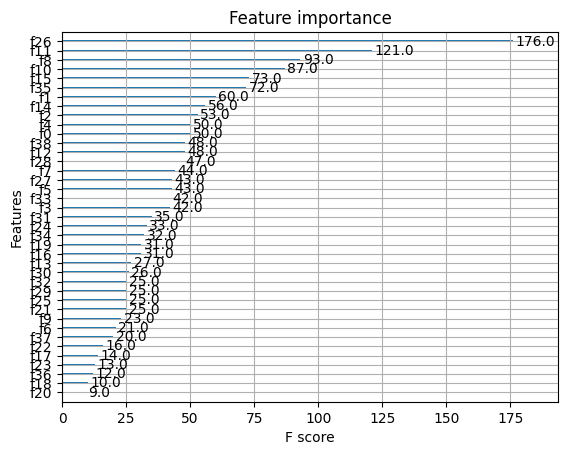

In [115]:
plotting.plot_importance(xgb_pipeline["regressor"])
plt.show()

In [116]:
xgboost_variables = variables_importance(xgb_pipeline, X)
xgboost_variables.head()

,Feature,Coefficient
23,lowestRespiration,0.150772
16,LOWESTstatsValue,0.092842
14,TOTALstressDuration,0.088135
10,bodyBattery.chargedValue,0.076062
26,restlessMomentCount,0.070236


#### 7.6 RandomForestRegressor modelis

In [117]:
rfr_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor_columns),
        (
            "regressor",
            RandomForestRegressor(n_estimators=1000, random_state=42, max_depth=50),
        ),
    ]
)

In [118]:
rfr_pipeline.fit(X1_train, y1_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('int', StandardScaler(),
                                                  Index(['totalKilocalories', 'activeKilocalories', 'totalSteps',
       'totalDistanceMeters', 'highlyActiveSeconds', 'activeSeconds',
       'moderateIntensityMinutes', 'floor_up', 'floor_down',
       'restingHeartRate', 'bodyBattery.chargedValue',
       'bodyBattery.drainedValue', 'TOTALaverageStre...
       'previous_day_awake_min', 'previous_day_unmeasurable_min',
       'previous_day_averageRespiration', 'previous_day_total_min',
       'previous_day_restlessMomentCount', 'previous_day_avgSleepStress',
       'previous_day_awakeCount', 'previous_day_lowestRespiration',
       'previous_day_highestRespiration'],
      dtype='object'))])),
                ('regressor',
                 RandomForestRegressor(max_depth=50, n_estimators=1000,
                                       random_state=42))])

In [119]:
y_pred_rf = rfr_pipeline.predict(X1_test)

In [120]:
rf_eff = model_effectivness(y1_test, y_pred_rf)
print(rf_eff)

Mean Absolute Error: 8.956468085106385
            Mean Squared Error: 121.49831587234043
            Root Mean Squared Error: 11.02262744867758
            R-squared: 0.5360719845916103


In [121]:
randomf_variables = variables_importance(rfr_pipeline, X)
randomf_variables.head()

,Feature,Coefficient
11,bodyBattery.drainedValue,0.390505
26,restlessMomentCount,0.170179
10,bodyBattery.chargedValue,0.164057
14,TOTALstressDuration,0.037269
16,LOWESTstatsValue,0.024730


#### 7.7 Klasifikatoriai

##### 7.7.1 Duomenų pasiruošimas

In [122]:
categorical_data = all_data.drop(
    columns=[
        "calendarDate",
        "Weekday",
        "sleepScores_overallScore",
        "sleepScores_feedback",
        "sleepScores_insight",
        "new_sleepScores_insight",
    ]
)

In [123]:
cat_columns = categorical_data.select_dtypes(include=["object", "category"]).columns
categorical_data[cat_columns] = categorical_data[cat_columns].astype(str)

In [124]:
Xcat = categorical_data.drop(columns="new_sleepScores_feedback")
ycat = categorical_data["new_sleepScores_feedback"]

In [125]:
Xcat_train, Xcat_test, ycat_train, ycat_test = train_test_split(
    Xcat,
    ycat,
    test_size=0.2,
    random_state=42,
    stratify=categorical_data["new_sleepScores_feedback"],
)

In [126]:
num_cols = Xcat.select_dtypes(include=["int64", "float64"]).columns
cat_cols = Xcat.select_dtypes(include=["object", "category"]).columns

preprocessor_columns_cat = ColumnTransformer(
    [("num", StandardScaler(), num_cols), ("cat", OneHotEncoder(), cat_cols)]
)

##### 7.7.2 Random Forest Klasifikatorius

In [127]:
cat_rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor_columns_cat),
        ("classifier", RandomForestClassifier(n_estimators=100, random_state=42)),
    ]
)

In [128]:
cat_rf_pipeline.fit(Xcat_train, ycat_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['totalKilocalories', 'activeKilocalories', 'totalSteps',
       'totalDistanceMeters', 'highlyActiveSeconds', 'activeSeconds',
       'moderateIntensityMinutes', 'floor_up', 'floor_down',
       'restingHeartRate', 'bodyBattery.chargedValue',
       'bodyBattery.drainedValue', 'TOTALaverageStre...
       'previous_day_sleepScores_overallScore', 'previous_day_total_min',
       'previous_day_restlessMomentCount', 'previous_day_avgSleepStress',
       'previous_day_awakeCount', 'previous_day_lowestRespiration',
       'previous_day_highestRespiration'],
      dtype='object')),
                                                 ('cat', OneHotEncoder(),
                                                  Index(['trainingStatus'], dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [129]:
ycat_pred_rf = cat_rf_pipeline.predict(Xcat_test)

In [130]:
# pasitikrinam kaip suveike modelis rf
print(metrics.accuracy_score(ycat_test, ycat_pred_rf))
print(metrics.classification_report(ycat_test, ycat_pred_rf))

0.7659574468085106
              precision    recall  f1-score   support

    NEGATIVE       0.76      0.73      0.74        22
    POSITIVE       0.77      0.80      0.78        25

    accuracy                           0.77        47
   macro avg       0.77      0.76      0.76        47
weighted avg       0.77      0.77      0.77        47



##### 7.7.3 Decision Tree klasifikatorius

In [131]:
tree_pipeline_cat = Pipeline(
    steps=[
        ("preprocessor", preprocessor_columns_cat),
        ("classifier", DecisionTreeClassifier()),
    ]
)

In [132]:
tree_pipeline_cat.fit(Xcat_train, ycat_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['totalKilocalories', 'activeKilocalories', 'totalSteps',
       'totalDistanceMeters', 'highlyActiveSeconds', 'activeSeconds',
       'moderateIntensityMinutes', 'floor_up', 'floor_down',
       'restingHeartRate', 'bodyBattery.chargedValue',
       'bodyBattery.drainedValue', 'TOTALaverageStre...
       'previous_day_sleepScores_overallScore', 'previous_day_total_min',
       'previous_day_restlessMomentCount', 'previous_day_avgSleepStress',
       'previous_day_awakeCount', 'previous_day_lowestRespiration',
       'previous_day_highestRespiration'],
      dtype='object')),
                                                 ('cat', OneHotEncoder(),
                                                  Index(['trainingStatus'], dtype='object'))])),
                ('classifier', DecisionTreeClassifier())])

In [133]:
ycat_pred_tree = tree_pipeline_cat.predict(Xcat_test)

In [134]:
# pasitikrinam kaip suveike modelis decision tree
print(metrics.accuracy_score(ycat_test, ycat_pred_tree))
print(metrics.classification_report(ycat_test, ycat_pred_tree))

0.7021276595744681
              precision    recall  f1-score   support

    NEGATIVE       0.64      0.82      0.72        22
    POSITIVE       0.79      0.60      0.68        25

    accuracy                           0.70        47
   macro avg       0.72      0.71      0.70        47
weighted avg       0.72      0.70      0.70        47



##### 7.7.4 Logistic Regression klasifikatorius

In [135]:
logreg_pipeline_cat = Pipeline(
    steps=[
        ("preprocessor", preprocessor_columns_cat),
        ("classifier", LogisticRegression()),
    ]
)

In [136]:
logreg_pipeline_cat.fit(Xcat_train, ycat_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['totalKilocalories', 'activeKilocalories', 'totalSteps',
       'totalDistanceMeters', 'highlyActiveSeconds', 'activeSeconds',
       'moderateIntensityMinutes', 'floor_up', 'floor_down',
       'restingHeartRate', 'bodyBattery.chargedValue',
       'bodyBattery.drainedValue', 'TOTALaverageStre...
       'previous_day_averageRespiration',
       'previous_day_sleepScores_overallScore', 'previous_day_total_min',
       'previous_day_restlessMomentCount', 'previous_day_avgSleepStress',
       'previous_day_awakeCount', 'previous_day_lowestRespiration',
       'previous_day_highestRespiration'],
      dtype='object')),
                                                 ('cat', OneHotEncoder(),
                                                  Index(['trainingStatus'], dtype='object'))])),
                ('classifier', LogisticRegression())])

In [137]:
ycat_pred_logreg = logreg_pipeline_cat.predict(Xcat_test)

In [138]:
# pasitikrinam kaip suveike modelis logistic regression
print(metrics.accuracy_score(ycat_test, ycat_pred_logreg))
print(metrics.classification_report(ycat_test, ycat_pred_logreg))

0.7446808510638298
              precision    recall  f1-score   support

    NEGATIVE       0.73      0.73      0.73        22
    POSITIVE       0.76      0.76      0.76        25

    accuracy                           0.74        47
   macro avg       0.74      0.74      0.74        47
weighted avg       0.74      0.74      0.74        47



### 8. Išvados
Ištikrųjų rezultatai labai varijuoja priklausomai nuo to koks modelis buvo pasirinktas. Vertinant modelius, kurių tikslumas 60+% matoma, kad daugiau įtakos rezultatams turi "BodyBattery" charged/drained values, šios reikšmės įvertina kaip buvo pailsėtą tą dieną. Vieninteliai linijinės regresijos modeliai atsižvelgia į aktyvumą, t.y. sudegintų kalorijų kiekį, bei koks atstumas buvo nueitas per dieną - šios savybės yra tarp top 5 savybių turinčių didžiausią svarbą modelio tikslumui. Paskutinė savybė atsidūrusi tarp top 5 turinčių didžiausią įtaką yra restlessMovementCount - tai yra kiek judesių buvo užfiksuota miego metu. Garmin puslapyje nurodyta, kad būtent judesių kiekis užfiksuotas miego metu prisideda nustant kokio tipo miegas yra užfiksuotas.   
Iš sukurtų modelių matyti, kad svarbiausia yra ne kiek žingsnių ar aukštų užlipsi, o tai kaip pailsėsi per visą dieną ir kaip tinkamai susidorosi su patiriamu stresu. 

In [139]:
print(
    f"""Linijinės regresijos modelis Nr.1: 
{lr_effect}"""
)
print("-" * 100)
print(
    f"""Linijinės regresijos modelis (patobulinta): 
{lr_effect1}"""
)
print("-" * 100)
print(
    f"""Ridge modelis: 
{ridge_eff}"""
)
print("-" * 100)
print(
    f"""Lasso modelis: 
{lasso_eff}"""
)
print("-" * 100)
print(
    f"""Gradient Boosting regresijos modelis: 
{gbr_eff}"""
)
print("-" * 100)
print(
    f"""XGBOOST regresijos modelis: 
{xgb_eff}"""
)
print("-" * 100)
print(
    f"""RandomForest regresijos modelis: 
{rf_eff}"""
)

Linijinės regresijos modelis Nr.1: 
Mean Absolute Error: 7.802501533993373
            Mean Squared Error: 104.74589373167841
            Root Mean Squared Error: 10.234544138928632
            R-squared: 0.6000392741889982
----------------------------------------------------------------------------------------------------
Linijinės regresijos modelis (patobulinta): 
Mean Absolute Error: 7.372313308001518
            Mean Squared Error: 79.4346438588251
            Root Mean Squared Error: 8.912611506108918
            R-squared: 0.7234323603901053
----------------------------------------------------------------------------------------------------
Ridge modelis: 
Mean Absolute Error: 7.7279849373375695
            Mean Squared Error: 103.37525680038848
            Root Mean Squared Error: 10.167362332502393
            R-squared: 0.6052729012299434
----------------------------------------------------------------------------------------------------
Lasso modelis: 
Mean Absolute Error: 7

Ateities planas išbandyti modelį surinkus daugiau duomenų.